# Import and Process

In [26]:
# Import EI and other functions
github_version = '04_04_23'
date = '3_22_2023' #of models
seed = '47'
path_to_ei = "/home/opc/ei-python/"
import sys
sys.path.append('/home/opc/Tadpole_Data')
#from Tadpole_EI_utils import *
import sys
sys.path.append(path_to_ei)
from ei import *
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import RobustScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from ei import EnsembleIntegration, MeanAggregation, MedianAggregation
from interpretation import *
import pandas as pd

from TADPOLE_FINAL_PIPELINE_utils import *

# Import EI Parameters

EI_old = EnsembleIntegration.load('/home/opc/Tadpole_Expanded/EI.MCI_BL')
base_pred = EI_old.base_predictors
meta_models = EI_old.meta_models
random_state = EI_old.random_state
sample_strategy = EI_old.sampling_strategy

# Import Data

import pickle
with open('MASTER_AE_8020.pickle', 'rb') as handle:
    MASTER_AE_8020 = pickle.load(handle)
with open('MCI_CN_FULL_DATA.pickle', 'rb') as handle:
    MASTER = pickle.load(handle)
with open('80_split.pickle', 'rb') as handle:
    mode_dict_split = pickle.load(handle)
with open('full_ext_test.pickle', 'rb') as handle:
    full_ext_test = pickle.load(handle)
with open('y_ext.pickle', 'rb') as handle:
    full_ext_test_labels = pickle.load(handle)
# Preprocess Data

full_and_split = {}
full_and_split['CN'] = {}
full_and_split['MCI'] = {}

for problem in full_and_split:

    ei_full_train_unprocessed = MASTER[problem]['Filtered']
    ei_full_labels = MASTER[problem]['Labels']

    ae_split_train_unprocessed = MASTER_AE_8020[problem][seed]['train']['data_filtered']
    ae_split_test_unprocessed = MASTER_AE_8020[problem][seed]['test']['data_filtered']
    ae_split_labels = MASTER_AE_8020[problem][seed]['train']['label']

    ei_split_train_unprocessed = mode_dict_split[problem][seed]['train']['data_filtered']
    ei_split_test_unprocessed = mode_dict_split[problem][seed]['test']['data_filtered']
    ei_split_labels = mode_dict_split[problem][seed]['train']['label']

    if problem == 'MCI':
        ei_full_ext_test_unprocessed = full_ext_test
        ae_split_ext_test_unprocessed = MASTER_AE_8020[problem][seed]['ext_test']['data_filtered']
        ei_split_ext_test_unprocessed = mode_dict_split[problem][seed]['ext_test']['data_filtered']

    ei_full_train_drop_modes = drop_modes(ei_full_train_unprocessed)

    ei_split_train_drop_modes = drop_modes(ei_split_train_unprocessed)
    ei_split_test_drop_modes = drop_modes(ei_split_test_unprocessed)

    ae_split_test_drop_modes = drop_modes(ae_split_test_unprocessed, delete_these_modes=['dti_roi', 'av1451_pet_roi'])
    ae_split_train_drop_modes = drop_modes(ae_split_train_unprocessed, delete_these_modes=['dti_roi', 'av1451_pet_roi'])

    if problem == 'MCI':
        ei_full_ext_test_drop_modes = drop_modes(ei_full_ext_test_unprocessed)
        ei_split_ext_test_drop_modes = drop_modes(ei_split_ext_test_unprocessed)
        ae_split_ext_test_drop_modes = drop_modes(ae_split_ext_test_unprocessed, delete_these_modes=['dti_roi', 'av1451_roi'])

    #ei_full_train_drop_modes['other'] = other_process(ei_full_train_drop_modes['other'])
    ei_split_train_drop_modes['other'] = other_process(ei_split_train_drop_modes['other'])
    ei_split_test_drop_modes['other'] = other_process(ei_split_test_drop_modes['other'])

    ae_split_train_drop_modes['other'] = other_process(ae_split_train_drop_modes['other'])
    ae_split_test_drop_modes['other'] = other_process(ae_split_test_drop_modes['other'])

    if problem == 'MCI':

        ei_full_ext_test_drop_modes['other'] = other_process(ei_full_ext_test_unprocessed['other'])
        ei_split_ext_test_drop_modes['other'] = other_process(ei_split_ext_test_unprocessed['other'])
        ae_split_ext_test_drop_modes['other'] = other_process(ae_split_ext_test_unprocessed['other'])
    
    ei_full_train_imputed = impute_per_mode(ei_full_train_drop_modes)
    ei_split_train_imputed, ei_split_test_imputed = impute_per_mode(ei_split_train_drop_modes, ei_split_test_drop_modes)
    ae_split_train_imputed, ae_split_test_imputed = impute_per_mode(ae_split_train_drop_modes, 
                                                                    ae_split_test_drop_modes)

    if problem == 'MCI':
        _, ei_full_ext_test_imputed = impute_per_mode(ei_full_train_drop_modes, ei_full_ext_test_drop_modes)
        _, ei_split_ext_test_imputed = impute_per_mode(ei_split_train_drop_modes, ei_split_ext_test_drop_modes)
        _, ae_split_ext_test_imputed = impute_per_mode(ae_split_train_drop_modes, ae_split_ext_test_drop_modes)
        
    ei_full_train_normalized = normalize_per_col(ei_full_train_imputed)
    ei_split_train_normalized, ei_split_test_normalized = normalize_per_col(ei_split_train_imputed, ei_split_test_imputed)
    ae_split_train_normalized, ae_split_test_normalized = normalize_per_col(ae_split_train_imputed, ae_split_test_imputed)
    if problem == 'MCI':
        _, ei_full_ext_test_normalized = normalize_per_col(ei_full_train_imputed, ei_full_ext_test_imputed)
        _, ei_split_ext_test_normalized = normalize_per_col(ei_split_train_imputed, ei_split_ext_test_imputed)
        _, ae_split_ext_test_normalized = normalize_per_col(ae_split_train_imputed, ae_split_ext_test_imputed)

    # Define Final Dict

    full_and_split[problem]['FULL'] = {}
    full_and_split[problem]['8020'] = {}
    full_and_split[problem]['ae_8020'] = {}
    
    full_and_split[problem]['FULL']['train'] = ei_full_train_normalized
    full_and_split[problem]['FULL']['labels'] = ei_full_labels

    full_and_split[problem]['8020']['train'] = ei_split_train_normalized
    full_and_split[problem]['8020']['labels'] = ei_split_labels
    full_and_split[problem]['8020']['test'] = ei_split_test_normalized
    full_and_split[problem]['8020']['test_labels'] = mode_dict_split[problem][seed]['test']['label']

    full_and_split[problem]['ae_8020']['train'] = ae_split_train_normalized
    full_and_split[problem]['ae_8020']['test'] = ae_split_test_normalized
    full_and_split[problem]['ae_8020']['labels'] = ae_split_labels
    full_and_split[problem]['ae_8020']['test_labels'] = MASTER_AE_8020[problem][seed]['test']['label']
    if problem == 'MCI':
        full_and_split[problem]['8020']['ext_test'] = ei_split_ext_test_normalized
        full_and_split[problem]['8020']['ext_test_labels'] = mode_dict_split[problem][seed]['ext_test']['label']
        full_and_split[problem]['FULL']['ext_test'] = ei_full_ext_test_normalized
        full_and_split[problem]['FULL']['ext_test_labels'] = full_ext_test_labels
        full_and_split[problem]['ae_8020']['ext_test'] = ae_split_ext_test_normalized
        full_and_split[problem]['ae_8020']['ext_test_labels'] = MASTER_AE_8020[problem][seed]['ext_test']['label']

    full_and_split[problem]['FULL_DF'] = MASTER['MCI']['Filtered']
    full_and_split[problem]['8020_DF'] = mode_dict_split[problem][seed]['train']['data_filtered']

keep_cols = []
for i in range(full_and_split['MCI']['ae_8020']['train']['fdg_pet_roi'].shape[1]):
    if np.isnan(full_and_split["MCI"]["ae_8020"]["train"]["fdg_pet_roi"][:,i]).sum() == 0:
        keep_cols +=[i]
full_and_split['MCI']['ae_8020']['train']['fdg_pet_roi'] = full_and_split['MCI']['ae_8020']['train']['fdg_pet_roi'][:, keep_cols]
full_and_split['MCI']['ae_8020']['ext_test']['fdg_pet_roi'] = full_and_split[problem]['ae_8020']['ext_test']['fdg_pet_roi'][:, keep_cols]

Set date

# Train

Train EI

In [2]:
#problem = 'MCI'
for problem in ['CN']:
        for data_split in ['8020']:
                x = full_and_split[problem][data_split]['train']
                y = full_and_split[problem][data_split]['labels']
                EI_model_train_and_save(f'{problem}_{data_split}_{date}_{seed}', base_predictors = base_pred, meta_models = meta_models, 
                                        mode_dict = x, 
                                        y = y.astype(int), train = True, random_state=42, 
                                        model_building=True)
                for modes in x.keys():
                        x_mode = x[modes]
                        EI_model_train_and_save(f'{problem}_{data_split}_{modes}_{date}_{seed}', 
                        base_predictors = base_pred, meta_models = meta_models, 
                        mode_dict = x_mode, 
                        y = y.astype(int), train = True, single_mode=True, 
                        mode_name=modes, random_state=42, model_building=True)



###############################################################################################################
######################################## main_cognitive_tests modality ########################################
############################################################################################################### 


Training base predictors and generating data for analysis...
Generating meta training data via nested cross validation...
Training base predictors on outer training sets...

Base predictor training is complete: see "base_summary" attribute for a summary of base predictor performance. Meta training data can be found in "meta_training_data" and "meta_test_data" attributes. Run "train_meta" method for analysis of ensemble algorithms.

Training base predictors and generating data for final ensemble...
Generating meta training data via nested cross validation...
Training base predictors on outer training sets...

Model building: meta training data for the 

Train XGBoost

In [9]:
from numpy import random
from sklearn.utils import shuffle
train = True
random_bl = False
modes_merged = {}
modes_merged['MCI'] = {}
modes_merged['CN'] = {}

for problem in ['MCI', 'CN']:
    modes_merged[problem]['FULL'] = pd.DataFrame()
    modes_merged[problem]['8020'] = pd.DataFrame()
    modes_merged[problem]['8020_test'] = pd.DataFrame()
    if problem == 'MCI':
        modes_merged[problem]['8020_ext_test'] = pd.DataFrame()
        modes_merged[problem]['FULL_ext_test'] = pd.DataFrame()
    for data_split in ['FULL', '8020']:
        for mode in full_and_split[problem][data_split]['train']:
            current_mode = full_and_split[problem][data_split]['train'][mode].copy()
            if data_split == '8020':
                current_mode_test = full_and_split[problem][data_split]['test'][mode].copy()
            if mode != 'other': 
                modes_merged[problem][data_split] = pd.concat([modes_merged[problem][data_split], 
                                                    pd.DataFrame(current_mode).astype(float)], axis=1)
                if data_split == '8020':
                    modes_merged[problem]['8020_test'] = pd.concat([modes_merged[problem]['8020_test'], 
                                                        pd.DataFrame(current_mode_test).astype(float)], axis=1)
                if problem == 'MCI':
                        modes_merged[problem][f'{data_split}_ext_test'] = pd.concat([modes_merged[problem][f'{data_split}_ext_test'], 
                                                        pd.DataFrame(full_and_split[problem][data_split]['ext_test'][mode]).astype(float)], axis=1)
            else:
                modes_merged[problem][data_split] = pd.concat([modes_merged[problem][data_split], 
                                                    pd.DataFrame(current_mode).astype(float)], axis=1)
                if data_split == '8020':
                    modes_merged[problem]['8020_test'] = pd.concat([modes_merged[problem]['8020_test'], 
                                                        pd.DataFrame(current_mode_test).astype(float)], axis=1)
                if problem == 'MCI':
                        modes_merged[problem][f'{data_split}_ext_test'] = pd.concat([modes_merged[problem][f'{data_split}_ext_test'], 
                                                        pd.DataFrame(full_and_split[problem][data_split]['ext_test'][mode])], axis=1)
                        
        if train == True:
            if random_bl == True:
                for i in range(50):
                    EI_model_train_and_save(f'XG_{problem}_RANDOM_{data_split}_{date}_{seed}_repeat_{i}', base_predictors = {"XGB": base_pred['XGB']}, mode_dict = np.array(modes_merged[problem][data_split]), 
                        y = shuffle(full_and_split[problem][data_split]['labels'].astype(int)), train = True, meta_training=False, random_state=i, single_mode=True, mode_name='ALL', model_building=True)
            else:
                 EI_model_train_and_save(f'XG_{problem}_{data_split}_{date}_{seed}', base_predictors = {"XGB": base_pred['XGB']}, mode_dict = np.array(modes_merged[problem][data_split]), 
                    y = full_and_split[problem][data_split]['labels'].astype(int), train = True, meta_training=False, random_state=42, single_mode=True, mode_name='ALL', model_building=True)
modes_merged_XG = modes_merged



##############################################################################################
######################################## ALL modality ########################################
############################################################################################## 


Training base predictors and generating data for analysis...
Generating meta training data via nested cross validation...
Training base predictors on outer training sets...

Base predictor training is complete: see "base_summary" attribute for a summary of base predictor performance. Meta training data can be found in "meta_training_data" and "meta_test_data" attributes. Run "train_meta" method for analysis of ensemble algorithms.

Training base predictors and generating data for final ensemble...
Generating meta training data via nested cross validation...
Training base predictors on outer training sets...

Model building: meta training data for the final model has been generated and can be found in 

Train stacked autoencoder

Hyperparamater optimization

In [29]:
import pickle
batch_size = 30
optimizer = 'adam'
loss_fn = keras.losses.MeanSquaredError() 
epochs = 100
lr_factor = 0.01
all_ae_preds = {}
all_ae_scores = {}
hyperparams = {'initial_tuning': [0.003, 0.001], #'fine_tuning': [.003, .001], 
               'dropout':[0, 0.2, 0.4, 0.6], 'hidden_layer1': [300, 200], 
               'hidden_layer2': [150, 100], 'hidden_layer3': [100, 75, 50]}
for problem in ['CN', 'MCI']:
    all_ae_preds[problem] = {}
    all_ae_scores[problem] = {}
    for data_split in ['8020', 'ae_8020']: #8020 is 30% missing data, ae_8020 is 70%
        if data_split == 'ae_8020' or problem == 'MCI':
          all_ae_preds[problem][data_split] = {}
          all_ae_scores[problem][data_split] = {}
          if data_split == '8020':
              x = modes_merged_XG[problem]['8020']
              x_test = modes_merged_XG[problem]['8020_test']
              if problem == 'MCI':
                  x_ext_test = modes_merged_XG[problem]['8020_ext_test']
                  y_ext_test = full_and_split[problem][data_split]['ext_test_labels']
          elif data_split == 'ae_8020':
              x = modes_merged_AE[problem]['8020']
              x_test = modes_merged_AE[problem]['8020_test']
              if problem == 'MCI':
                  x_ext_test = modes_merged_AE[problem]['8020_ext_test']
                  y_ext_test = full_and_split[problem][data_split]['ext_test_labels']
          y = full_and_split[problem][data_split]['labels'].astype(int)
          y_test = full_and_split[problem][data_split]['test_labels']
          x_train, y = shuffle(x, y)
          kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state = 42)
          #x_train = x

          acc_per_fold = []

          input_size = x_train.shape
          #epochs = 60
          input_dim = input_size[1]

          y_pred = np.zeros(y.shape)
          shuffled = 0
          tuned_hyperparams = {}
          tuning_stages = range(4)
          for stage in tuning_stages:
            print(f'\n---------- STAGE {stage} ----------\n')
            tuned_hyperparams[stage] = {}
            for param in hyperparams:
              print(f'\n--- PARAMETER = {param} ---\n')
              current_params = {}

              for other_params in hyperparams:
                if (other_params != param) and (stage == 0):
                  if other_params in tuned_hyperparams[stage].keys():
                    current_params[other_params] = tuned_hyperparams[stage][other_params]
                  else:
                    current_params[other_params] = hyperparams[other_params][0]
                if (other_params != param) and (stage > 0):
                  if other_params in tuned_hyperparams[stage].keys():
                    current_params[other_params] = tuned_hyperparams[stage][other_params]
                  else:  
                    current_params[other_params] = tuned_hyperparams[stage-1][other_params]

              sos = []    
              for p, vals in enumerate(hyperparams[param]):
                current_params[param] = vals
                
                acc_per_fold = []
                fold_no = 1
                y_pred = np.zeros(y.shape)

                for train, test in kfold.split(x_train, y): 

                  x_sample, y_sample = sample(
                            x_train.iloc[train, :], y[train], strategy='hybrid', random_state=42)

                  autoencoder_1 = create_ae(current_params['hidden_layer1'], dropout_rate=current_params['dropout'], 
                                            lr=current_params['initial_tuning'], input_dim = input_dim, loss_fn = loss_fn, optimizer = optimizer)
                  autoencoder_2 = create_ae(current_params['hidden_layer2'], dropout_rate=current_params['dropout'],
                                            lr=current_params['initial_tuning'], input_dim = input_dim, loss_fn = loss_fn, optimizer = optimizer)
                  autoencoder_3 = create_ae(current_params['hidden_layer3'], dropout_rate=current_params['dropout'], 
                                            lr=current_params['initial_tuning'], input_dim = input_dim, loss_fn = loss_fn, optimizer = optimizer)

                  ae2_input = ae_fit_and_predict(autoencoder_1, x_sample, epochs = epochs, batch_size=batch_size)
                  ae3_input = ae_fit_and_predict(autoencoder_2, ae2_input, epochs = epochs, batch_size=batch_size)
                  classifier_input = ae_fit_and_predict(autoencoder_3, ae3_input, epochs = epochs, batch_size=batch_size)
                  classifier_model = classifier(classifier_input, y_sample, epochs = epochs, input_dim = input_dim)
                  final_stack = classifier_model.fit(classifier_input, y_sample, epochs=epochs, 
                                              batch_size=batch_size, verbose=0)
                  
                  scores = classifier_model.evaluate(x_train.iloc[test, :], y[test])
                  y_pred[test] = classifier_model.predict(x_train.iloc[test, :], verbose=0).T[0]
                  #print(y_pred)

                  acc = [scores[1]*100]
                  acc_per_fold += [acc]
                  #print(f'\nClass imbalance ratio = {100 * max(1-y[train].sum(), y[train].sum())/len(y[train])}\n')
                  fold_no += 1

                sos.append(abs(y_pred ** 2 - y ** 2).sum())
              tmp = min(sos)
              idx = sos.index(tmp)
              tuned_hyperparams[stage][param] = hyperparams[param][idx]
              print(hyperparams[param])
              print(sos)
              print(f'Best val for {param} is {tuned_hyperparams[stage][param]}')
              current_params[param]

          with open(f'AE_{problem}_{data_split}_params.pkl', 'wb') as f:
            pickle.dump(tuned_hyperparams, f)


---------- STAGE 0 ----------


--- PARAMETER = initial_tuning ---

3/3 [==============================] - 0s 2ms/step - loss: 0.5123 - accuracy: 0.6914
[0.003, 0.001]
[119.79716026769137, 123.5473633988691]
Best val for initial_tuning is 0.003

--- PARAMETER = dropout ---

3/3 [==============================] - 0s 2ms/step - loss: 0.8182 - accuracy: 0.5556
[0, 0.2, 0.4, 0.6]
[113.88162322263047, 130.88739459392767, 137.74183380179954, 141.77062363236737]
Best val for dropout is 0

--- PARAMETER = hidden_layer1 ---

3/3 [==============================] - 0s 2ms/step - loss: 0.5002 - accuracy: 0.6790
[300, 200]
[130.40254218620083, 113.31251397612675]
Best val for hidden_layer1 is 200

--- PARAMETER = hidden_layer2 ---

3/3 [==============================] - 0s 2ms/step - loss: 0.6960 - accuracy: 0.6173
[150, 100]
[121.23598911528202, 115.1482124396004]
Best val for hidden_layer2 is 100

--- PARAMETER = hidden_layer3 ---

3/3 [==============================] - 0s 2ms/step - loss: 0.727

In [4]:
modes_merged = {}
modes_merged['MCI'] = {}
modes_merged['CN'] = {}
splits = ['8020']

checkpoint_filepath = '/home/opc/model_checkpoints/model_checkpoints_subfolder/'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

def get_ae_scores(y_true, y_pred, fmax_threshold = None):
    auc = roc_auc_score(y_true.astype(int), y_pred)
    fmax_min = fmeasure_score(y_true.astype(int), y_pred, pos_label=1)
    if fmax_threshold == None:
        fmax_thresh = fmax_min['thres']
    else:
        fmax_thresh = fmax_threshold
    fscore_maj = fmeasure_score(y_true.astype(int), y_pred, pos_label=0, thres=fmax_thresh)
    return auc, fmax_min['F'], fscore_maj['F'], fmax_thresh

for problem in ['MCI', 'CN']:
    #modes_merged[problem]['FULL'] = pd.DataFrame()
    modes_merged[problem]['8020'] = pd.DataFrame()
    modes_merged[problem]['8020_test'] = pd.DataFrame()
    if problem == 'MCI':
        modes_merged[problem]['8020_ext_test'] = pd.DataFrame()
        #modes_merged[problem]['FULL_ext_test'] = pd.DataFrame()
    for data_split in splits:
        for mode in full_and_split[problem][f'ae_{data_split}']['train']:
            current_mode = full_and_split[problem][f'ae_{data_split}']['train'][mode].copy()
            if data_split == '8020':
                current_mode_test = full_and_split[problem][f'ae_{data_split}']['test'][mode].copy()
            if mode != 'other': 
                modes_merged[problem][data_split] = pd.concat([modes_merged[problem][data_split], 
                                                    pd.DataFrame(current_mode).astype(float)], axis=1)
                if data_split == '8020':
                    modes_merged[problem]['8020_test'] = pd.concat([modes_merged[problem]['8020_test'], 
                                                        pd.DataFrame(current_mode_test).astype(float)], axis=1)
                if problem == 'MCI':
                        modes_merged[problem][f'{data_split}_ext_test'] = pd.concat([modes_merged[problem][f'{data_split}_ext_test'], 
                                                        pd.DataFrame(full_and_split[problem][f'ae_{data_split}']['ext_test'][mode]).astype(float)], axis=1)
            else:
                modes_merged[problem][data_split] = pd.concat([modes_merged[problem][data_split], 
                                                    pd.DataFrame(current_mode).astype(float)], axis=1)
                if data_split == '8020':
                    modes_merged[problem]['8020_test'] = pd.concat([modes_merged[problem]['8020_test'], 
                                                        pd.DataFrame(current_mode_test).astype(float)], axis=1)
                if problem == 'MCI':
                        modes_merged[problem][f'{data_split}_ext_test'] = pd.concat([modes_merged[problem][f'{data_split}_ext_test'], 
                                                        pd.DataFrame(full_and_split[problem][f'ae_{data_split}']['ext_test'][mode])], axis=1)
                        
#Concatenated Data
modes_merged_AE = modes_merged

batch_size = 15
optimizer = 'adam'
loss_fn = keras.losses.MeanSquaredError() 
epochs = 100
lr_factor = 0.01
all_ae_preds = {}
all_ae_scores = {}

for problem in ['CN', 'MCI']:
    all_ae_preds[problem] = {}
    all_ae_scores[problem] = {}
    for data_split in ['8020', 'ae_8020']: #8020 is 30% missing data, ae_8020 is 70%
        all_ae_preds[problem][data_split] = {}
        all_ae_scores[problem][data_split] = {}
        if data_split == '8020':
            x = modes_merged_XG[problem]['8020']
            x_test = modes_merged_XG[problem]['8020_test']
            if problem == 'MCI':
                x_ext_test = modes_merged_XG[problem]['8020_ext_test']
                y_ext_test = full_and_split[problem][data_split]['ext_test_labels']
        elif data_split == 'ae_8020':
            x = modes_merged_AE[problem]['8020']
            x_test = modes_merged_AE[problem]['8020_test']
            if problem == 'MCI':
                x_ext_test = modes_merged_AE[problem]['8020_ext_test']
                y_ext_test = full_and_split[problem][data_split]['ext_test_labels']
        y = full_and_split[problem][data_split]['labels'].astype(int)
        y_test = full_and_split[problem][data_split]['test_labels']
        x_train, y = shuffle(x, y)
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state = 42)
        #x_train = x
        acc_per_fold = []
        fold_no = 1
        y_pred = np.zeros(y.shape)
        shuffled = 0
    
        input_size = x_train.shape
        #epochs = 60
        input_dim = input_size[1]

        '''
        if problem == 'CN':
            with open('cn_saved_params.pkl', 'rb') as f:
                loaded_dict = pickle.load(f)
            tuned_params = loaded_dict[3]
        else:
            with open('saved_params.pkl', 'rb') as f:
                loaded_dict = pickle.load(f)
            tuned_params = loaded_dict[3]
        '''
        with open(f'AE_{problem}_{data_split}_params.pkl', 'rb') as f:
            loaded_dict = pickle.load(f)
        tuned_params = loaded_dict[3]
            
        print(f'Problem: {problem}')
        print(f'Data split: {data_split}')
        for train, test in kfold.split(x_train, y): 
            print(f'[ ---------- Fold {fold_no} ---------- ]')
            
            x_sample, y_sample = sample(
                    x_train.iloc[train,:], y[train], strategy='hybrid', random_state=42)
            #x_sample = x_sample.T
            #x_sample = x_train.iloc[train, :]
            #y_sample = y[train]
            
            autoencoder_1 = create_ae(tuned_params['hidden_layer1'], dropout_rate=tuned_params['dropout'], 
                                            lr=tuned_params['initial_tuning']*lr_factor, input_dim=input_dim,
                                            loss_fn = loss_fn, optimizer=optimizer)
            autoencoder_2 = create_ae(tuned_params['hidden_layer2'], dropout_rate=tuned_params['dropout'], 
                                            lr=tuned_params['initial_tuning']*lr_factor, input_dim=input_dim,
                                            loss_fn = loss_fn, optimizer=optimizer)
            autoencoder_3 = create_ae(tuned_params['hidden_layer3'], dropout_rate=tuned_params['dropout'], 
                                            lr=tuned_params['initial_tuning']*lr_factor, input_dim=input_dim,
                                            loss_fn = loss_fn, optimizer=optimizer)

            ae2_input = ae_fit_and_predict(autoencoder_1, x_sample, epochs=epochs, batch_size=batch_size)
            ae3_input = ae_fit_and_predict(autoencoder_2, ae2_input, epochs=epochs, batch_size=batch_size)
            classifier_input = ae_fit_and_predict(autoencoder_3, ae3_input, epochs=epochs, batch_size=batch_size)
            classifier_model = classifier(classifier_input, y_sample, input_dim=input_dim, epochs=epochs)
            final_stack = classifier_model.fit(classifier_input, y_sample, epochs=epochs, 
                                        batch_size=batch_size, verbose=0, callbacks = [model_checkpoint_callback])
            
            if os.path.exists(checkpoint_filepath + 'checkpoint'):
                classifier_model.load_weights(checkpoint_filepath)
            
            y_pred[test] = classifier_model.predict(x_train.iloc[test,:], verbose=0).T[0]
            del_checkpoints()
            fold_no += 1

        all_ae_preds[problem][data_split]['training'] = y_pred

        auc, fmax, fscore, fmax_thresh = get_ae_scores(y, y_pred)
        all_ae_scores[problem][data_split]['training'] = {'AUC': auc, 'fmax (minority)': fmax, 
                                                         'f (majority)': fscore, 'fmax_thresh': fmax_thresh}

        y_test_pred = np.zeros(y_test.shape)
        if problem == 'MCI':
            y_ext_test_pred = np.zeros(y_ext_test.shape)

        x_sample, y_sample = sample(x_train, y, strategy='hybrid', random_state=42)
        #x_sample = x_sample.T
        
        autoencoder_1 = create_ae(tuned_params['hidden_layer1'], dropout_rate=tuned_params['dropout'], 
                                        lr=tuned_params['initial_tuning']*lr_factor, input_dim=input_dim,
                                        loss_fn = loss_fn, optimizer=optimizer)
        autoencoder_2 = create_ae(tuned_params['hidden_layer2'], dropout_rate=tuned_params['dropout'], 
                                        lr=tuned_params['initial_tuning']*lr_factor, input_dim=input_dim,
                                        loss_fn = loss_fn, optimizer=optimizer)
        autoencoder_3 = create_ae(tuned_params['hidden_layer3'], dropout_rate=tuned_params['dropout'], 
                                        lr=tuned_params['initial_tuning']*lr_factor, input_dim=input_dim,
                                        loss_fn = loss_fn, optimizer=optimizer)

        ae2_input = ae_fit_and_predict(autoencoder_1, x_sample, epochs=epochs, batch_size=batch_size)
        ae3_input = ae_fit_and_predict(autoencoder_2, ae2_input, epochs=epochs, batch_size=batch_size)
        classifier_input = ae_fit_and_predict(autoencoder_3, ae3_input, epochs=epochs, batch_size=batch_size)
        classifier_model = classifier(classifier_input, y_sample, input_dim=input_dim, epochs=epochs)

        final_stack = classifier_model.fit(classifier_input, y_sample, epochs=epochs, 
                                    batch_size=batch_size, verbose=0, callbacks = [model_checkpoint_callback])
        
        if os.path.exists(checkpoint_filepath + 'checkpoint'):
            classifier_model.load_weights(checkpoint_filepath)

        all_ae_preds[problem][data_split]['first_test_set'] = classifier_model.predict(x_test, verbose=0).T[0]
        del_checkpoints()
        
        auc, fmax, fscore, fmax_thresh = get_ae_scores(y_test, all_ae_preds[problem][data_split]['first_test_set'], 
                                                       all_ae_scores[problem][data_split]['training']['fmax_thresh'])
        all_ae_scores[problem][data_split]['first_test_set'] = {'AUC': auc, 'fmax (minority)': fmax, 
                                                         'f (majority)': fscore, 'fmax_thresh': fmax_thresh}
        if problem == 'MCI':
            all_ae_preds[problem][data_split]['second_test_set'] = classifier_model.predict(x_ext_test, verbose=0).T[0]
            auc, fmax, fscore, fmax_thresh = get_ae_scores(y_ext_test, all_ae_preds[problem][data_split]['second_test_set'], 
                                                       all_ae_scores[problem][data_split]['training']['fmax_thresh'])
            all_ae_scores[problem][data_split]['second_test_set'] = {'AUC': auc, 'fmax (minority)': fmax, 
                                                         'f (majority)': fscore, 'fmax_thresh': fmax_thresh}

Problem: CN
Data split: 8020
[ ---------- Fold 1 ---------- ]
[ ---------- Fold 2 ---------- ]
[ ---------- Fold 3 ---------- ]
[ ---------- Fold 4 ---------- ]
[ ---------- Fold 5 ---------- ]
Problem: CN
Data split: ae_8020
[ ---------- Fold 1 ---------- ]
[ ---------- Fold 2 ---------- ]
[ ---------- Fold 3 ---------- ]
[ ---------- Fold 4 ---------- ]
[ ---------- Fold 5 ---------- ]


In [5]:
#Batch size 10 with 100 epochs = AUC .54
all_ae_scores

{'CN': {'8020': {'training': {'AUC': 0.5660290098801767,
    'fmax (minority)': 0.3275862068965517,
    'f (majority)': 0.9054054054054054,
    'fmax_thresh': 0.1850290596485138},
   'first_test_set': {'AUC': 0.44907407407407407,
    'fmax (minority)': 0.35416666666666674,
    'f (majority)': 0.9032258064516129,
    'fmax_thresh': 0.1850290596485138}},
  'ae_8020': {'training': {'AUC': 0.47466890897624553,
    'fmax (minority)': 0.3076923076923077,
    'f (majority)': 0.8839779005524862,
    'fmax_thresh': 0.3003903925418854},
   'first_test_set': {'AUC': 0.40343915343915343,
    'fmax (minority)': 0.35294117647058826,
    'f (majority)': 0.8666666666666666,
    'fmax_thresh': 0.3003903925418854}}}}

# Test

In [6]:
test_results_dict = {}

EI

In [7]:
for problem in ['CN']:
    for data_split in ['8020']:
        EI_model = EnsembleIntegration.load(f'EI.{problem}_{data_split}_{date}_{seed}')
        if problem == 'CN' and data_split == 'FULL':
            print('')
        else:
            if problem == 'MCI':
                x_ext_test = full_and_split[problem][data_split]['ext_test']
                y_ext_test = full_and_split[problem][data_split]['ext_test_labels']
                pos = EI_model.meta_summary['metrics'].T['fmax (minority)'].argmax()
                meta_model_key = EI_model.meta_summary['metrics'].T.iloc[pos].name
                preds = EI_model.predict(x_ext_test, meta_model_key=meta_model_key)
                fmax_minor_thresh = list(EI_model.meta_summary['thresholds'][meta_model_key])[0]
                metrics = {}
                metrics['AUC'] = [roc_auc_score(y_ext_test, preds)]
                metrics['fmax (minority)'] = [fmeasure_score(y_ext_test, preds, pos_label=1, thres=fmax_minor_thresh)['F']]
                metrics['f (majority)'] = [fmeasure_score(y_ext_test, preds, pos_label=0, thres=1-fmax_minor_thresh)['F']]
                test_results_dict[f'EI_{problem}_{data_split}_external_test_set'] = metrics
            
            if data_split == '8020':
                x_test = full_and_split[problem][data_split]['test']
                y_test = full_and_split[problem][data_split]['test_labels']
                pos = EI_model.meta_summary['metrics'].T['fmax (minority)'].argmax()
                meta_model_key = EI_model.meta_summary['metrics'].T.iloc[pos].name
                preds = EI_model.predict(x_test, meta_model_key=meta_model_key)
                fmax_minor_thresh = list(EI_model.meta_summary['thresholds'][meta_model_key])[0]
                metrics = {}
                metrics['AUC'] = [roc_auc_score(y_test, preds)]
                metrics['fmax (minority)'] = [fmeasure_score(y_test, preds, pos_label=1, thres=fmax_minor_thresh)['F']]
                metrics['f (majority)'] = [fmeasure_score(y_test, preds, pos_label=0, thres=1-fmax_minor_thresh)['F']]
                test_results_dict[f'EI_{problem}_{data_split}_20%_holdout_test_set'] = metrics

XGBoost

In [10]:
import copy
random_bl = False
for problem in ['MCI', 'CN']:
    for data_split in ['FULL', '8020']:
        if random_bl == True:
            model_name = f'EI.XG_{problem}_RANDOM_{data_split}'
            XGboost_model = EnsembleIntegration.load(f'EI.XG_{problem}_RANDOM_{data_split}_{date}_{seed}_repeat_18')
        else:
            model_name = f'EI.XG_{problem}_{data_split}'
            XGboost_model = EnsembleIntegration.load(f'EI.XG_{problem}_{data_split}_{date}_{seed}')
        base_models_list = copy.deepcopy(XGboost_model.final_models["base models"]["ALL"])
        XGB_dicts = [dictionary for dictionary in base_models_list if dictionary["model name"] == "XGB"]
        XGB_model = pickle.loads(XGB_dicts[0]["pickled model"])
        if problem == 'CN' and data_split == 'FULL':
            print('')
        else:
            if problem == 'MCI':
                x_ext_test = modes_merged_XG[problem][f'{data_split}_ext_test']
                y_ext_test = full_and_split[problem][data_split]['ext_test_labels']
                preds = XGB_model.predict(x_ext_test)
                fmax_minor_thresh = XGboost_model.base_summary['thresholds']['ALL']['XGB'][0]
                metrics = {}
                metrics['AUC'] = [roc_auc_score(y_ext_test, preds)]
                metrics['fmax (minority)'] = [fmeasure_score(y_ext_test, preds, pos_label=1, thres=fmax_minor_thresh)['F']]
                metrics['f (majority)'] = [fmeasure_score(y_ext_test, preds, pos_label=0, thres=1-fmax_minor_thresh)['F']]
                test_results_dict[f'{model_name}_external_test_set'] = metrics
            
            if data_split == '8020':
                x_test = modes_merged_XG[problem][f'{data_split}_test']
                y_test = full_and_split[problem][data_split]['test_labels']
                preds = XGB_model.predict(x_test)
                fmax_minor_thresh = XGboost_model.base_summary['thresholds']['ALL']['XGB'][0]
                metrics = {}
                metrics['AUC'] = [roc_auc_score(y_test, preds)]
                metrics['fmax (minority)'] = [fmeasure_score(y_test, preds, pos_label=1, thres=fmax_minor_thresh)['F']]
                metrics['f (majority)'] = [fmeasure_score(y_test, preds, pos_label=0, thres=1-fmax_minor_thresh)['F']]
                test_results_dict[f'{model_name}_20%_holdout_test_set'] = metrics

In [11]:
test_results_dict

{'EI_CN_8020_20%_holdout_test_set': {'AUC': [0.6772486772486773],
  'fmax (minority)': [0.3703703703703704],
  'f (majority)': [0.7733333333333333]},
 'EI.XG_MCI_FULL_external_test_set': {'AUC': [0.5863970588235294],
  'fmax (minority)': [0.34146341463414637],
  'f (majority)': [0.7874015748031497]},
 'EI.XG_MCI_8020_external_test_set': {'AUC': [0.5974264705882353],
  'fmax (minority)': [0.36000000000000004],
  'f (majority)': [0.728813559322034]},
 'EI.XG_MCI_8020_20%_holdout_test_set': {'AUC': [0.6125349487418452],
  'fmax (minority)': [0.5185185185185185],
  'f (majority)': [0.6798029556650247]},
 'EI.XG_CN_8020_20%_holdout_test_set': {'AUC': [0.5813492063492064],
  'fmax (minority)': [0.3181818181818182],
  'f (majority)': [0.8125]}}

# Plot

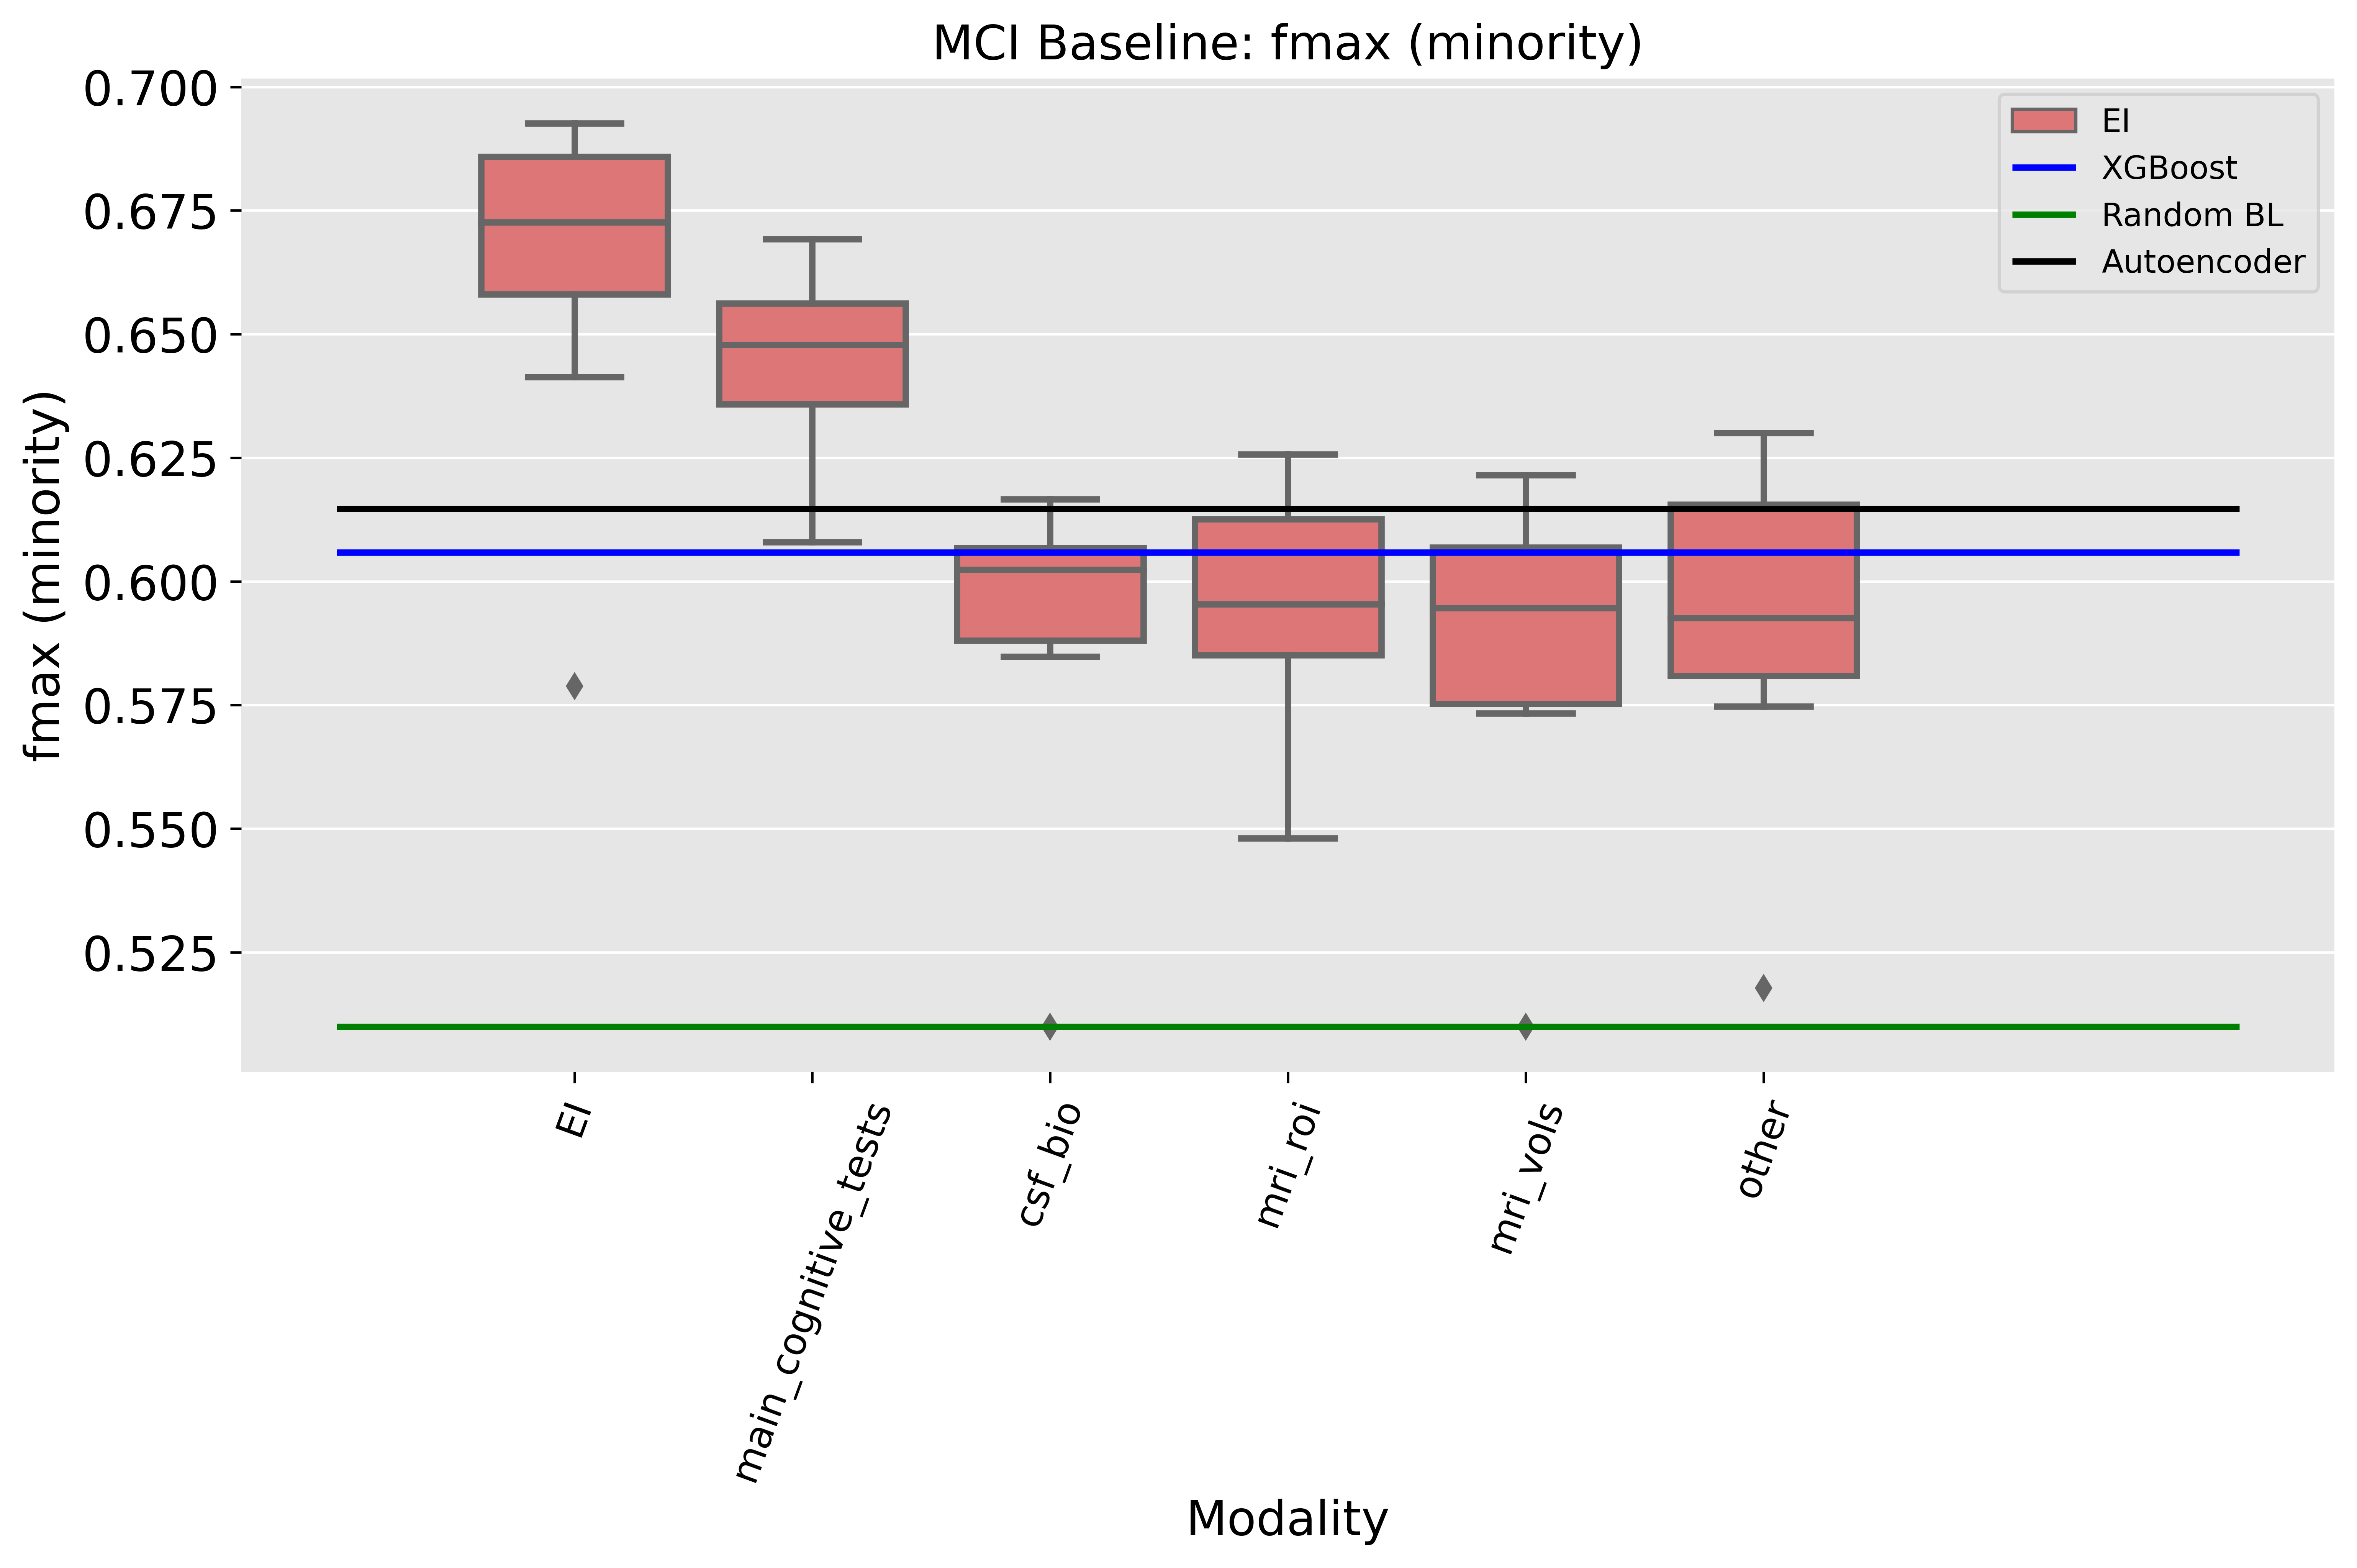

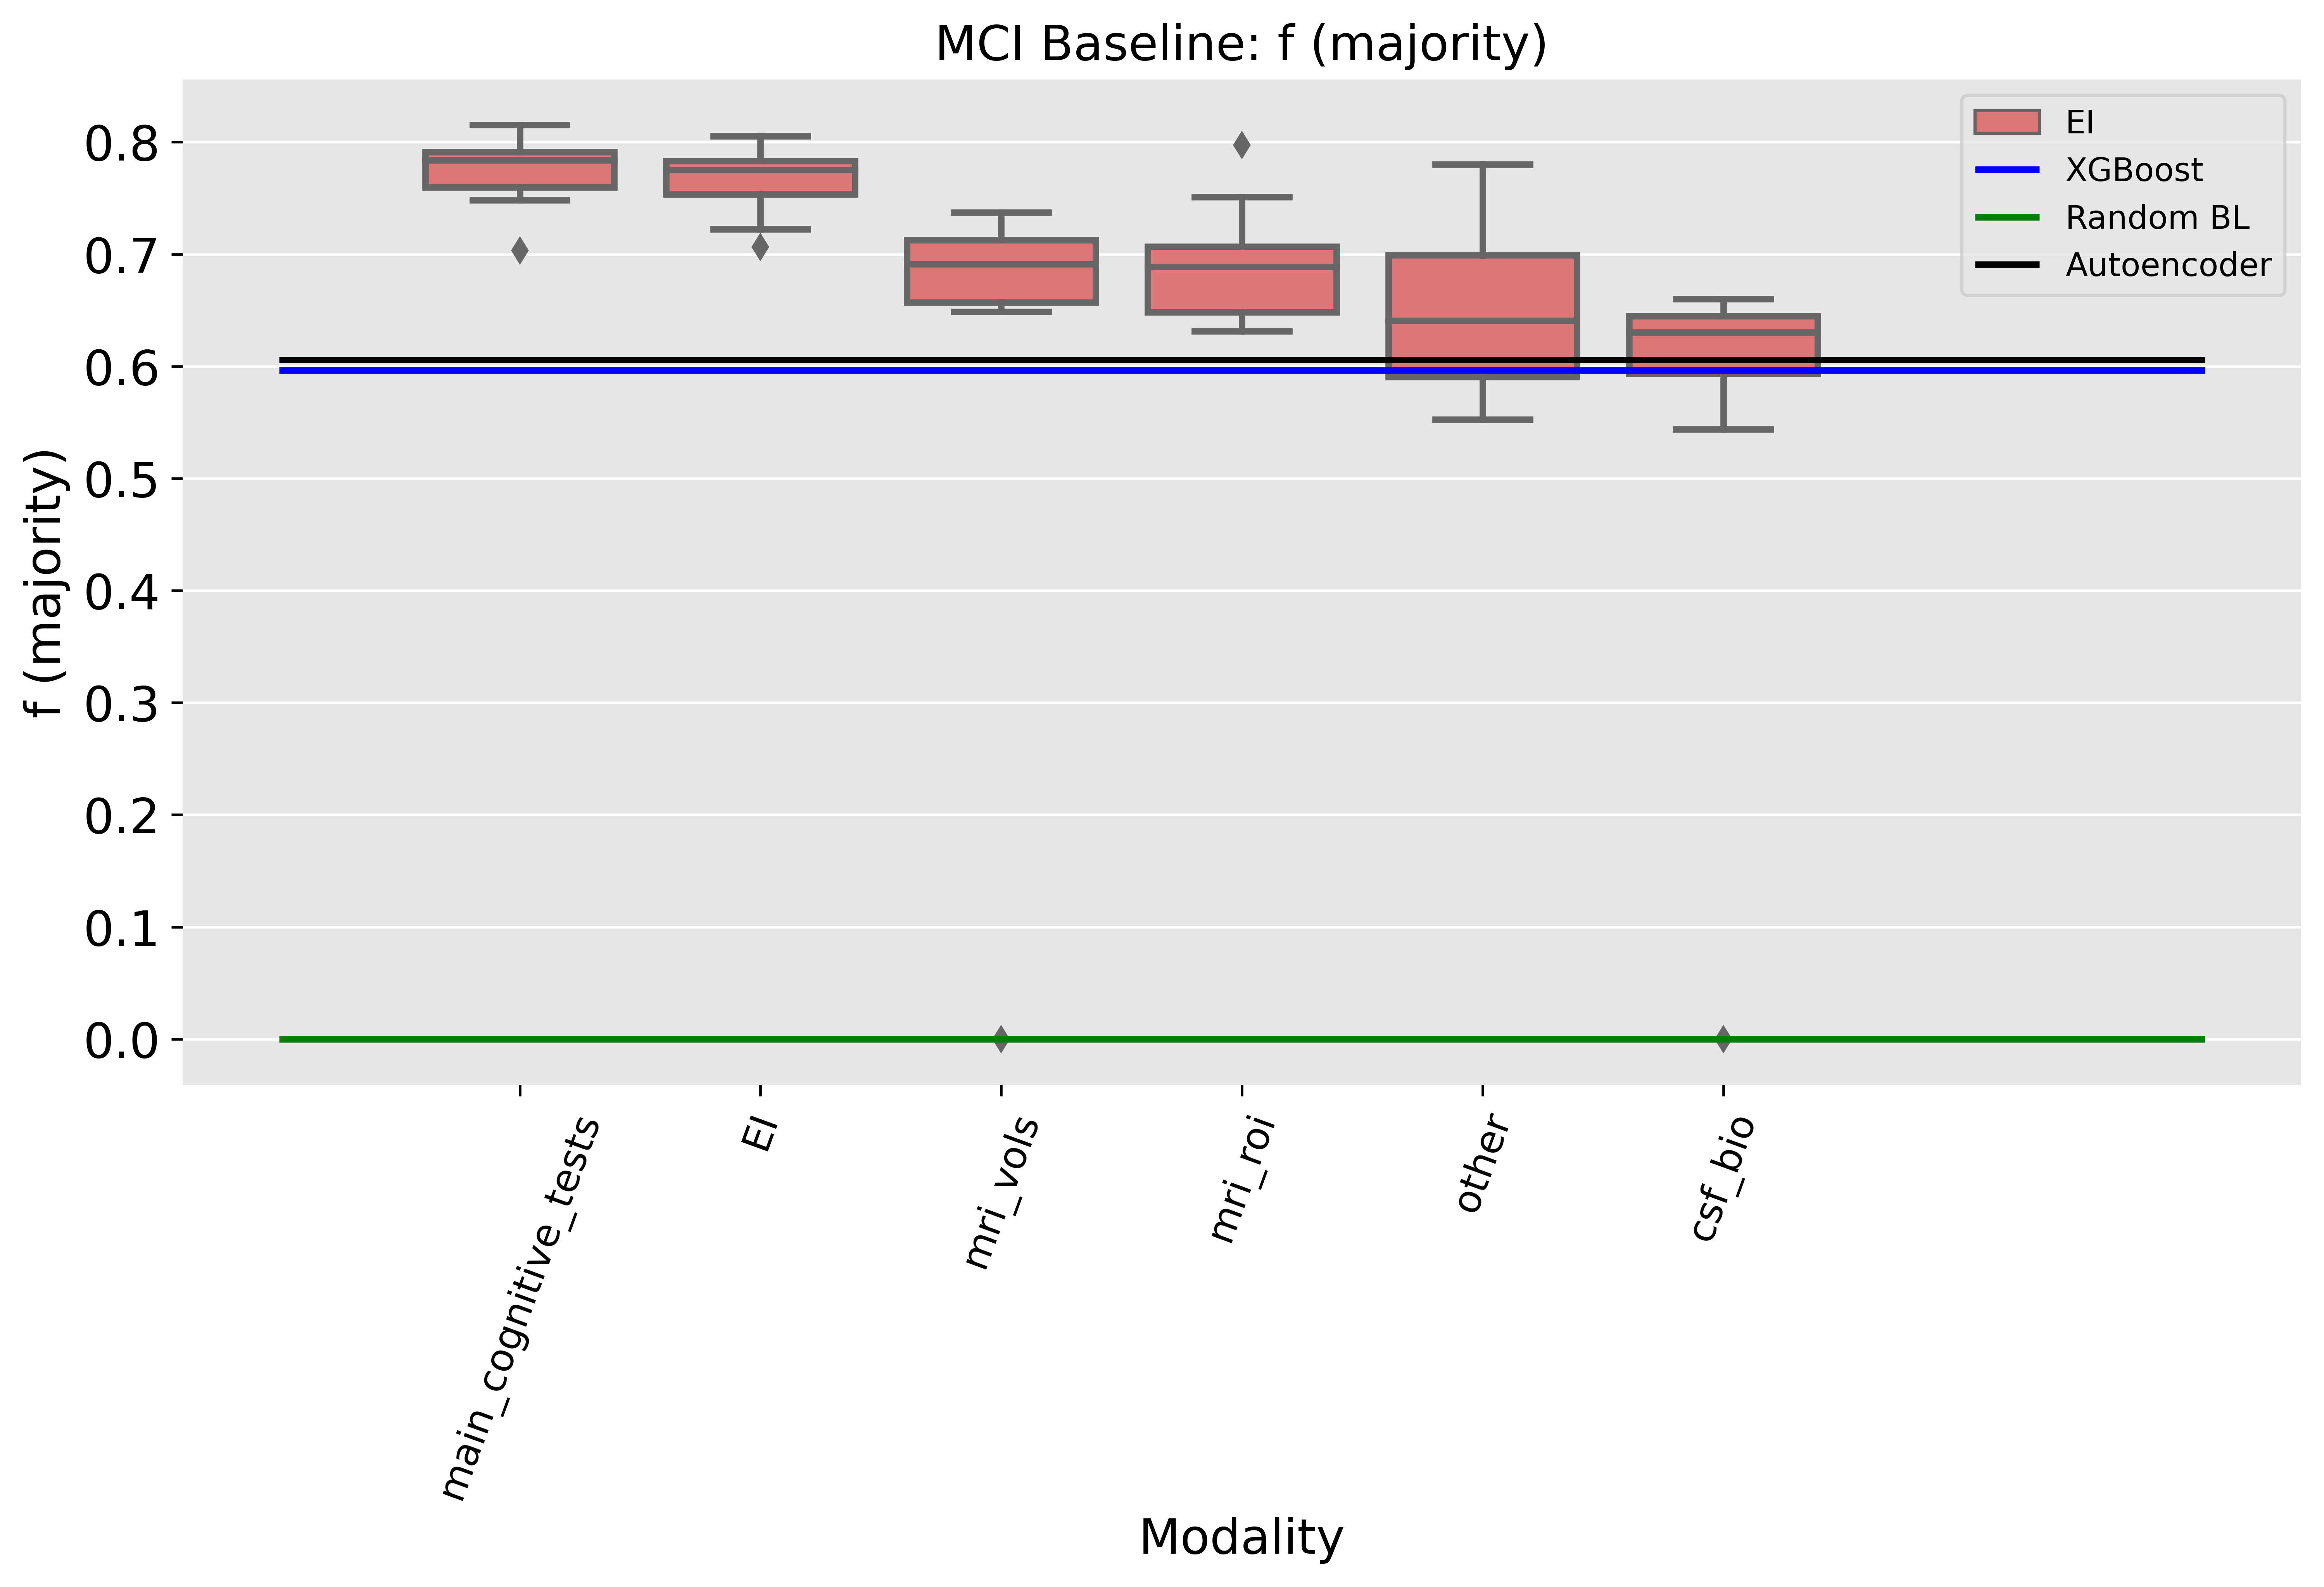

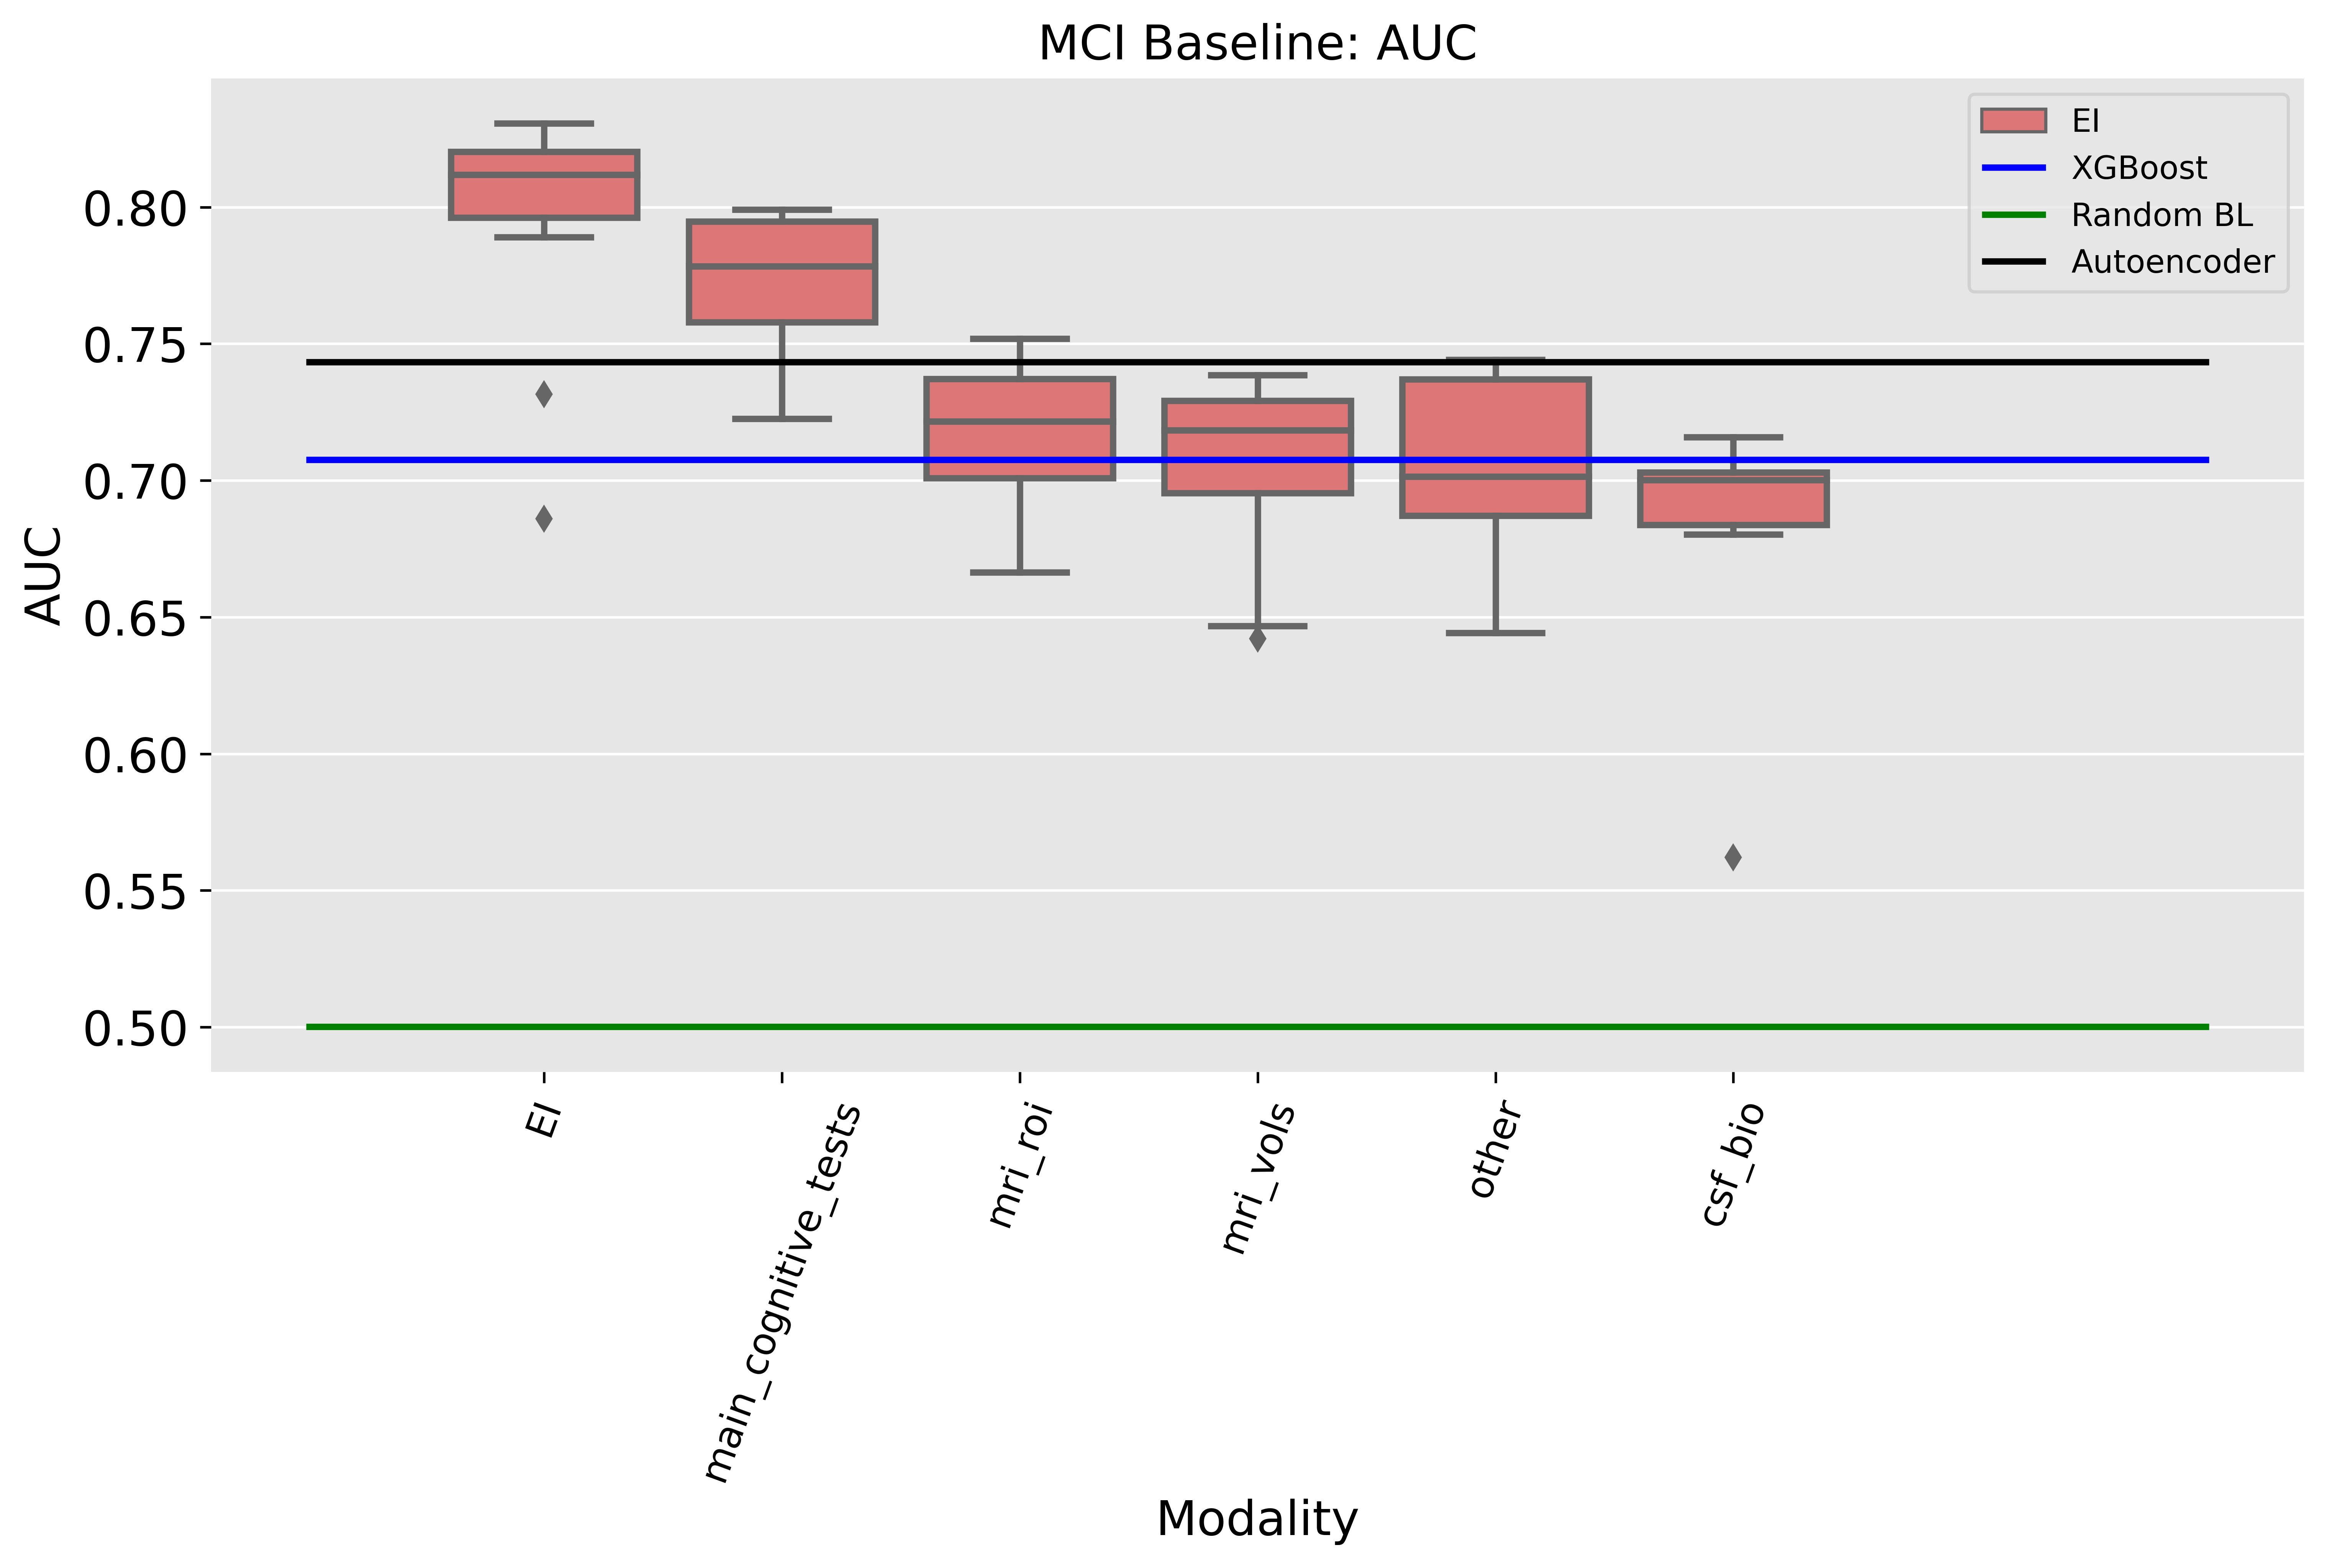

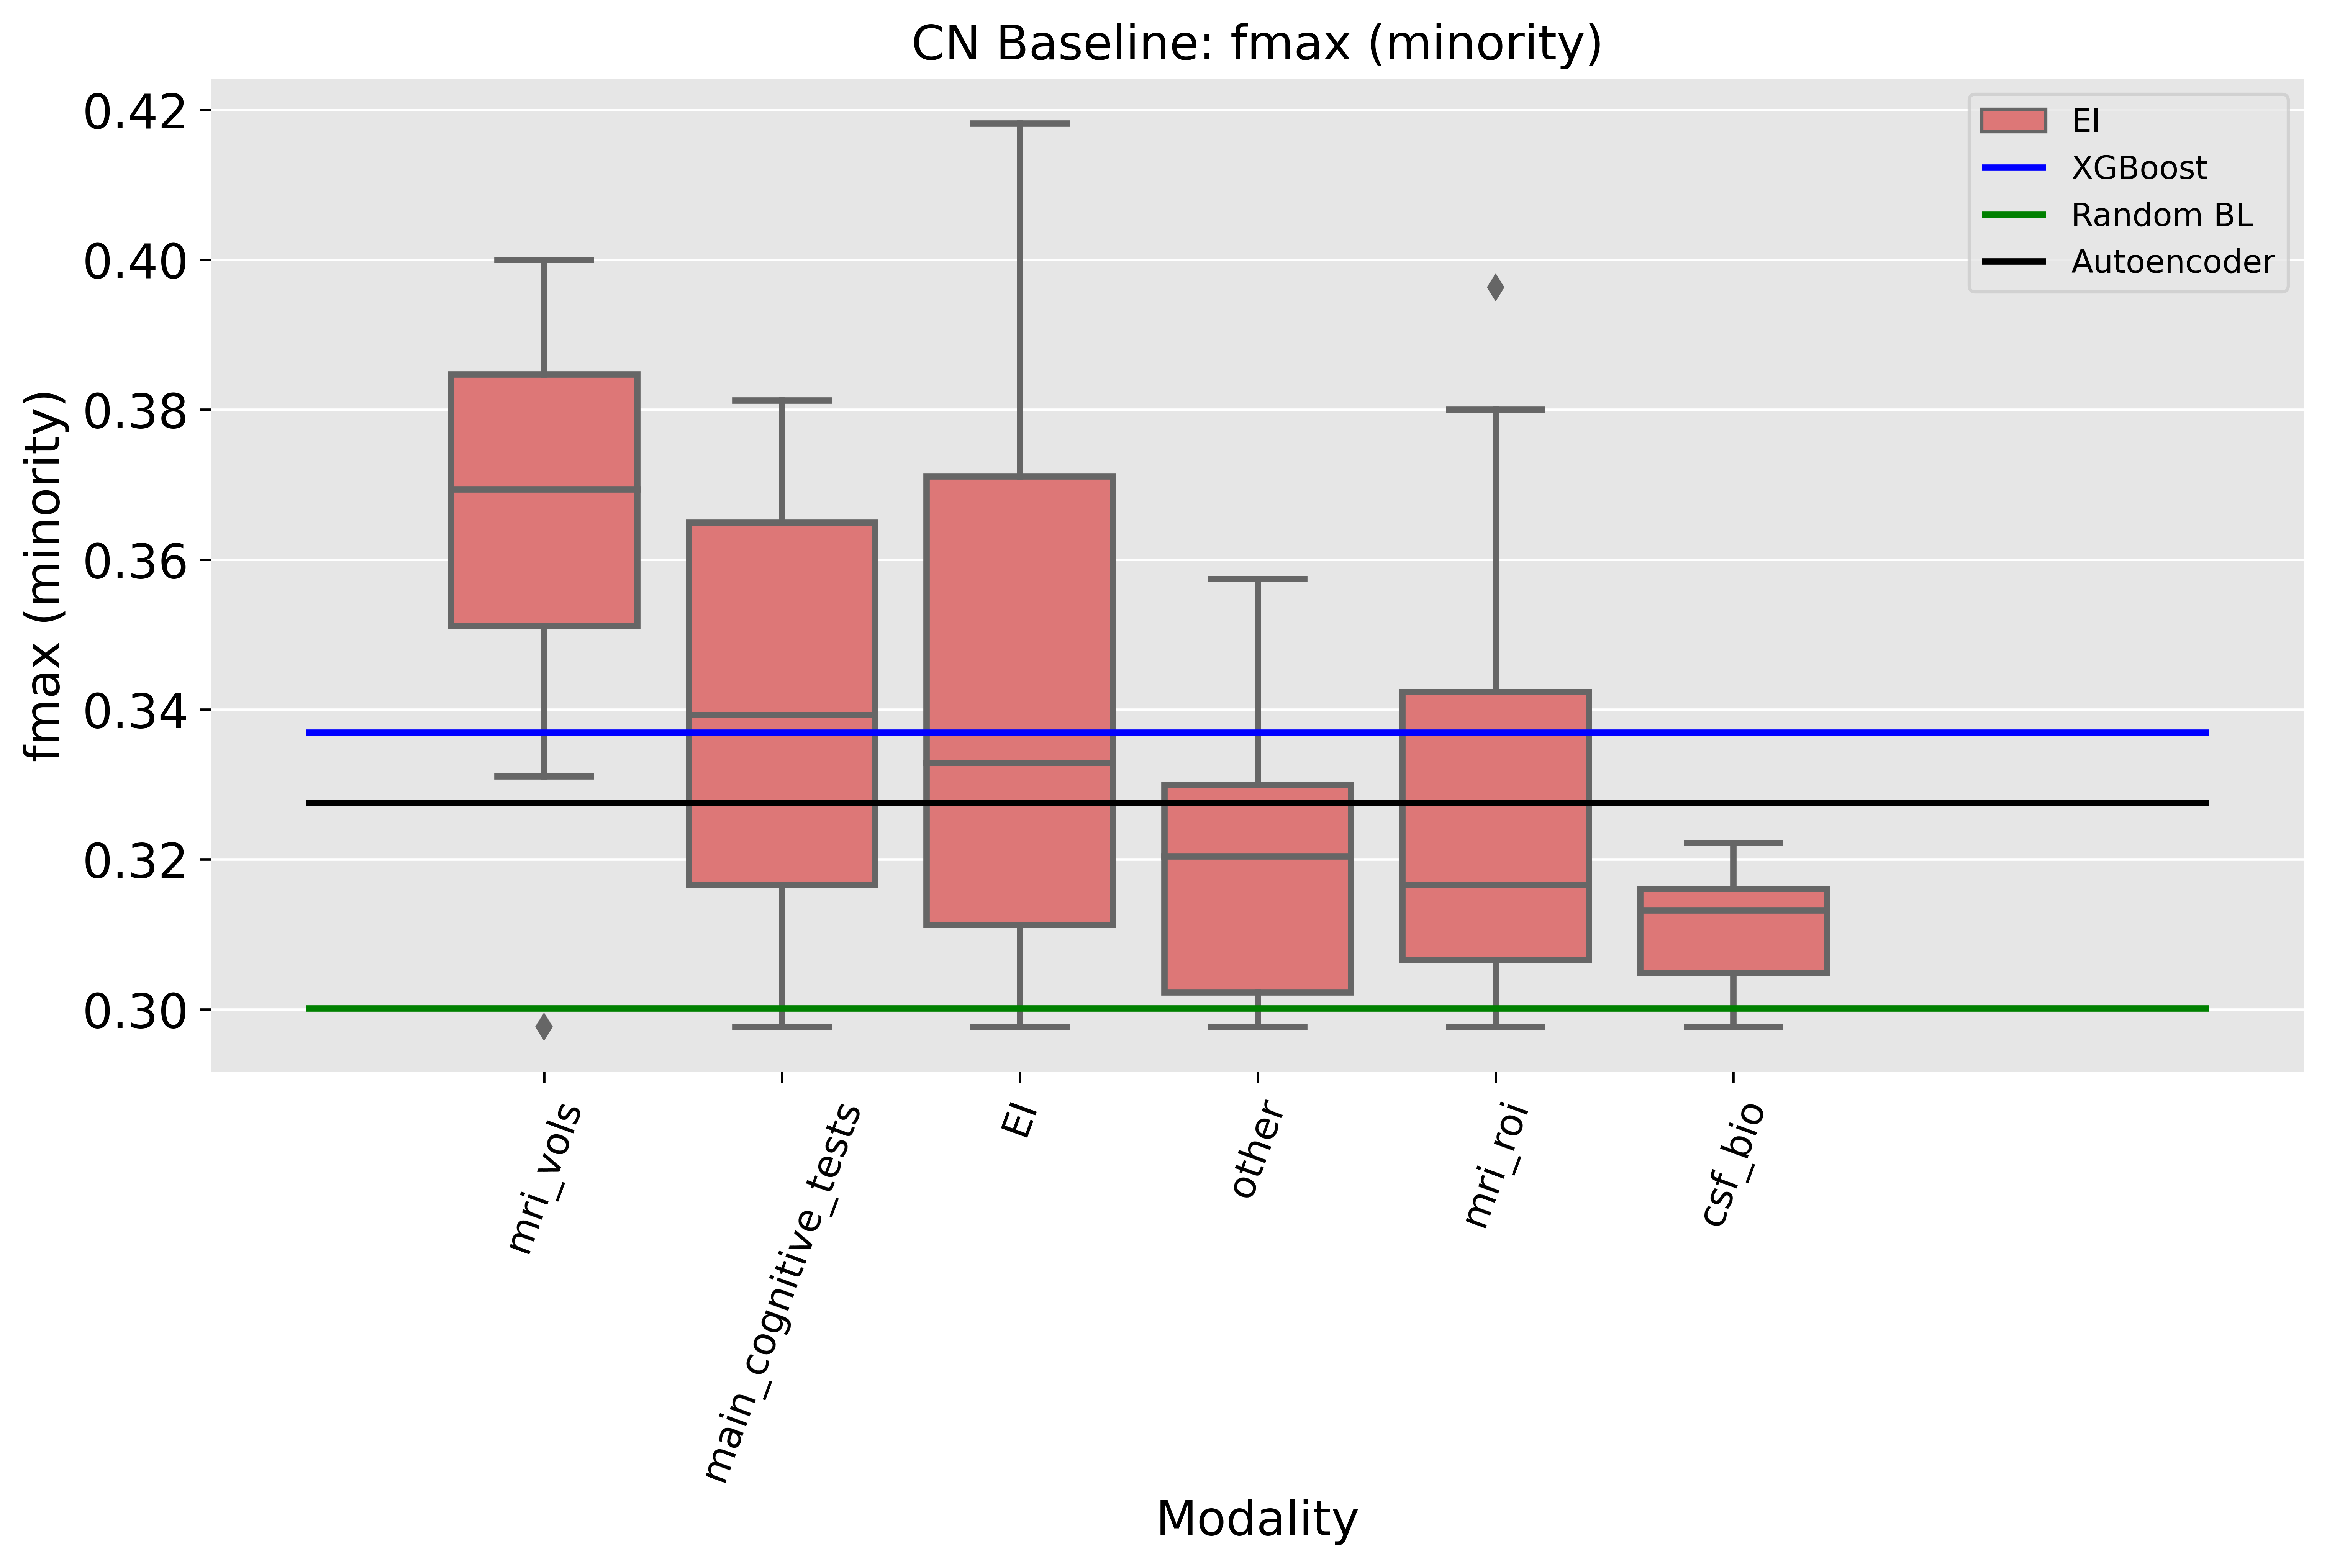

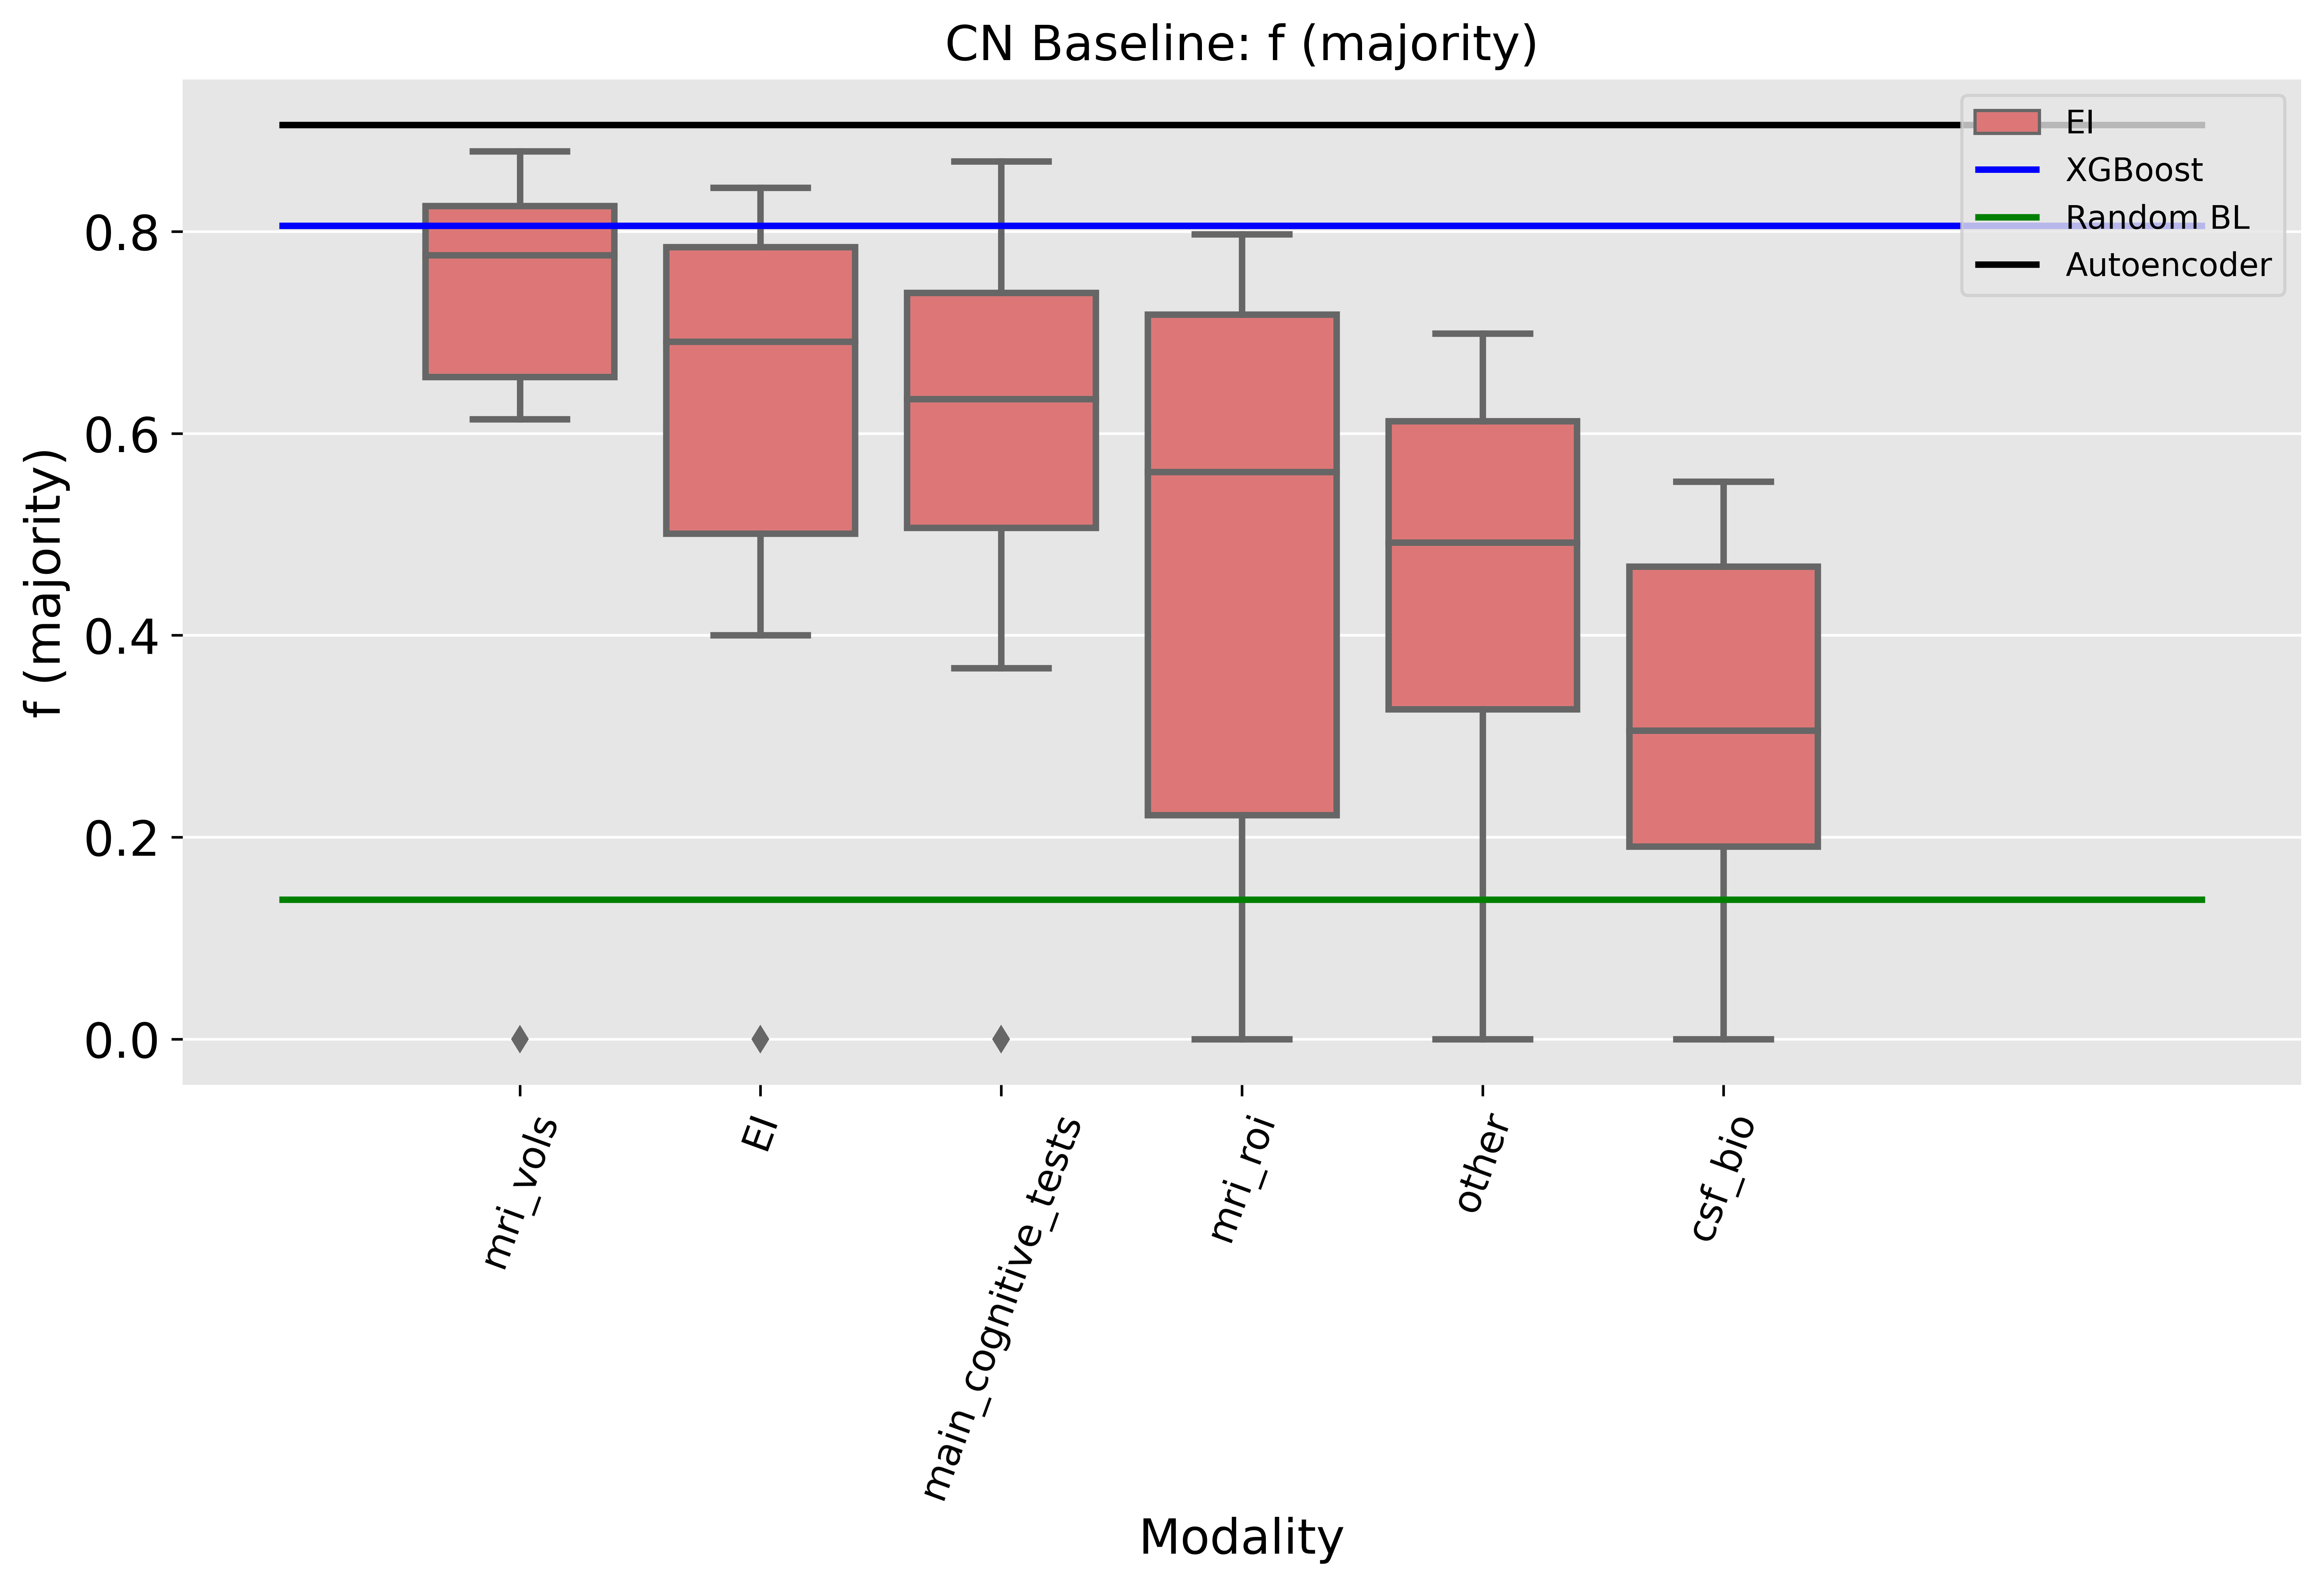

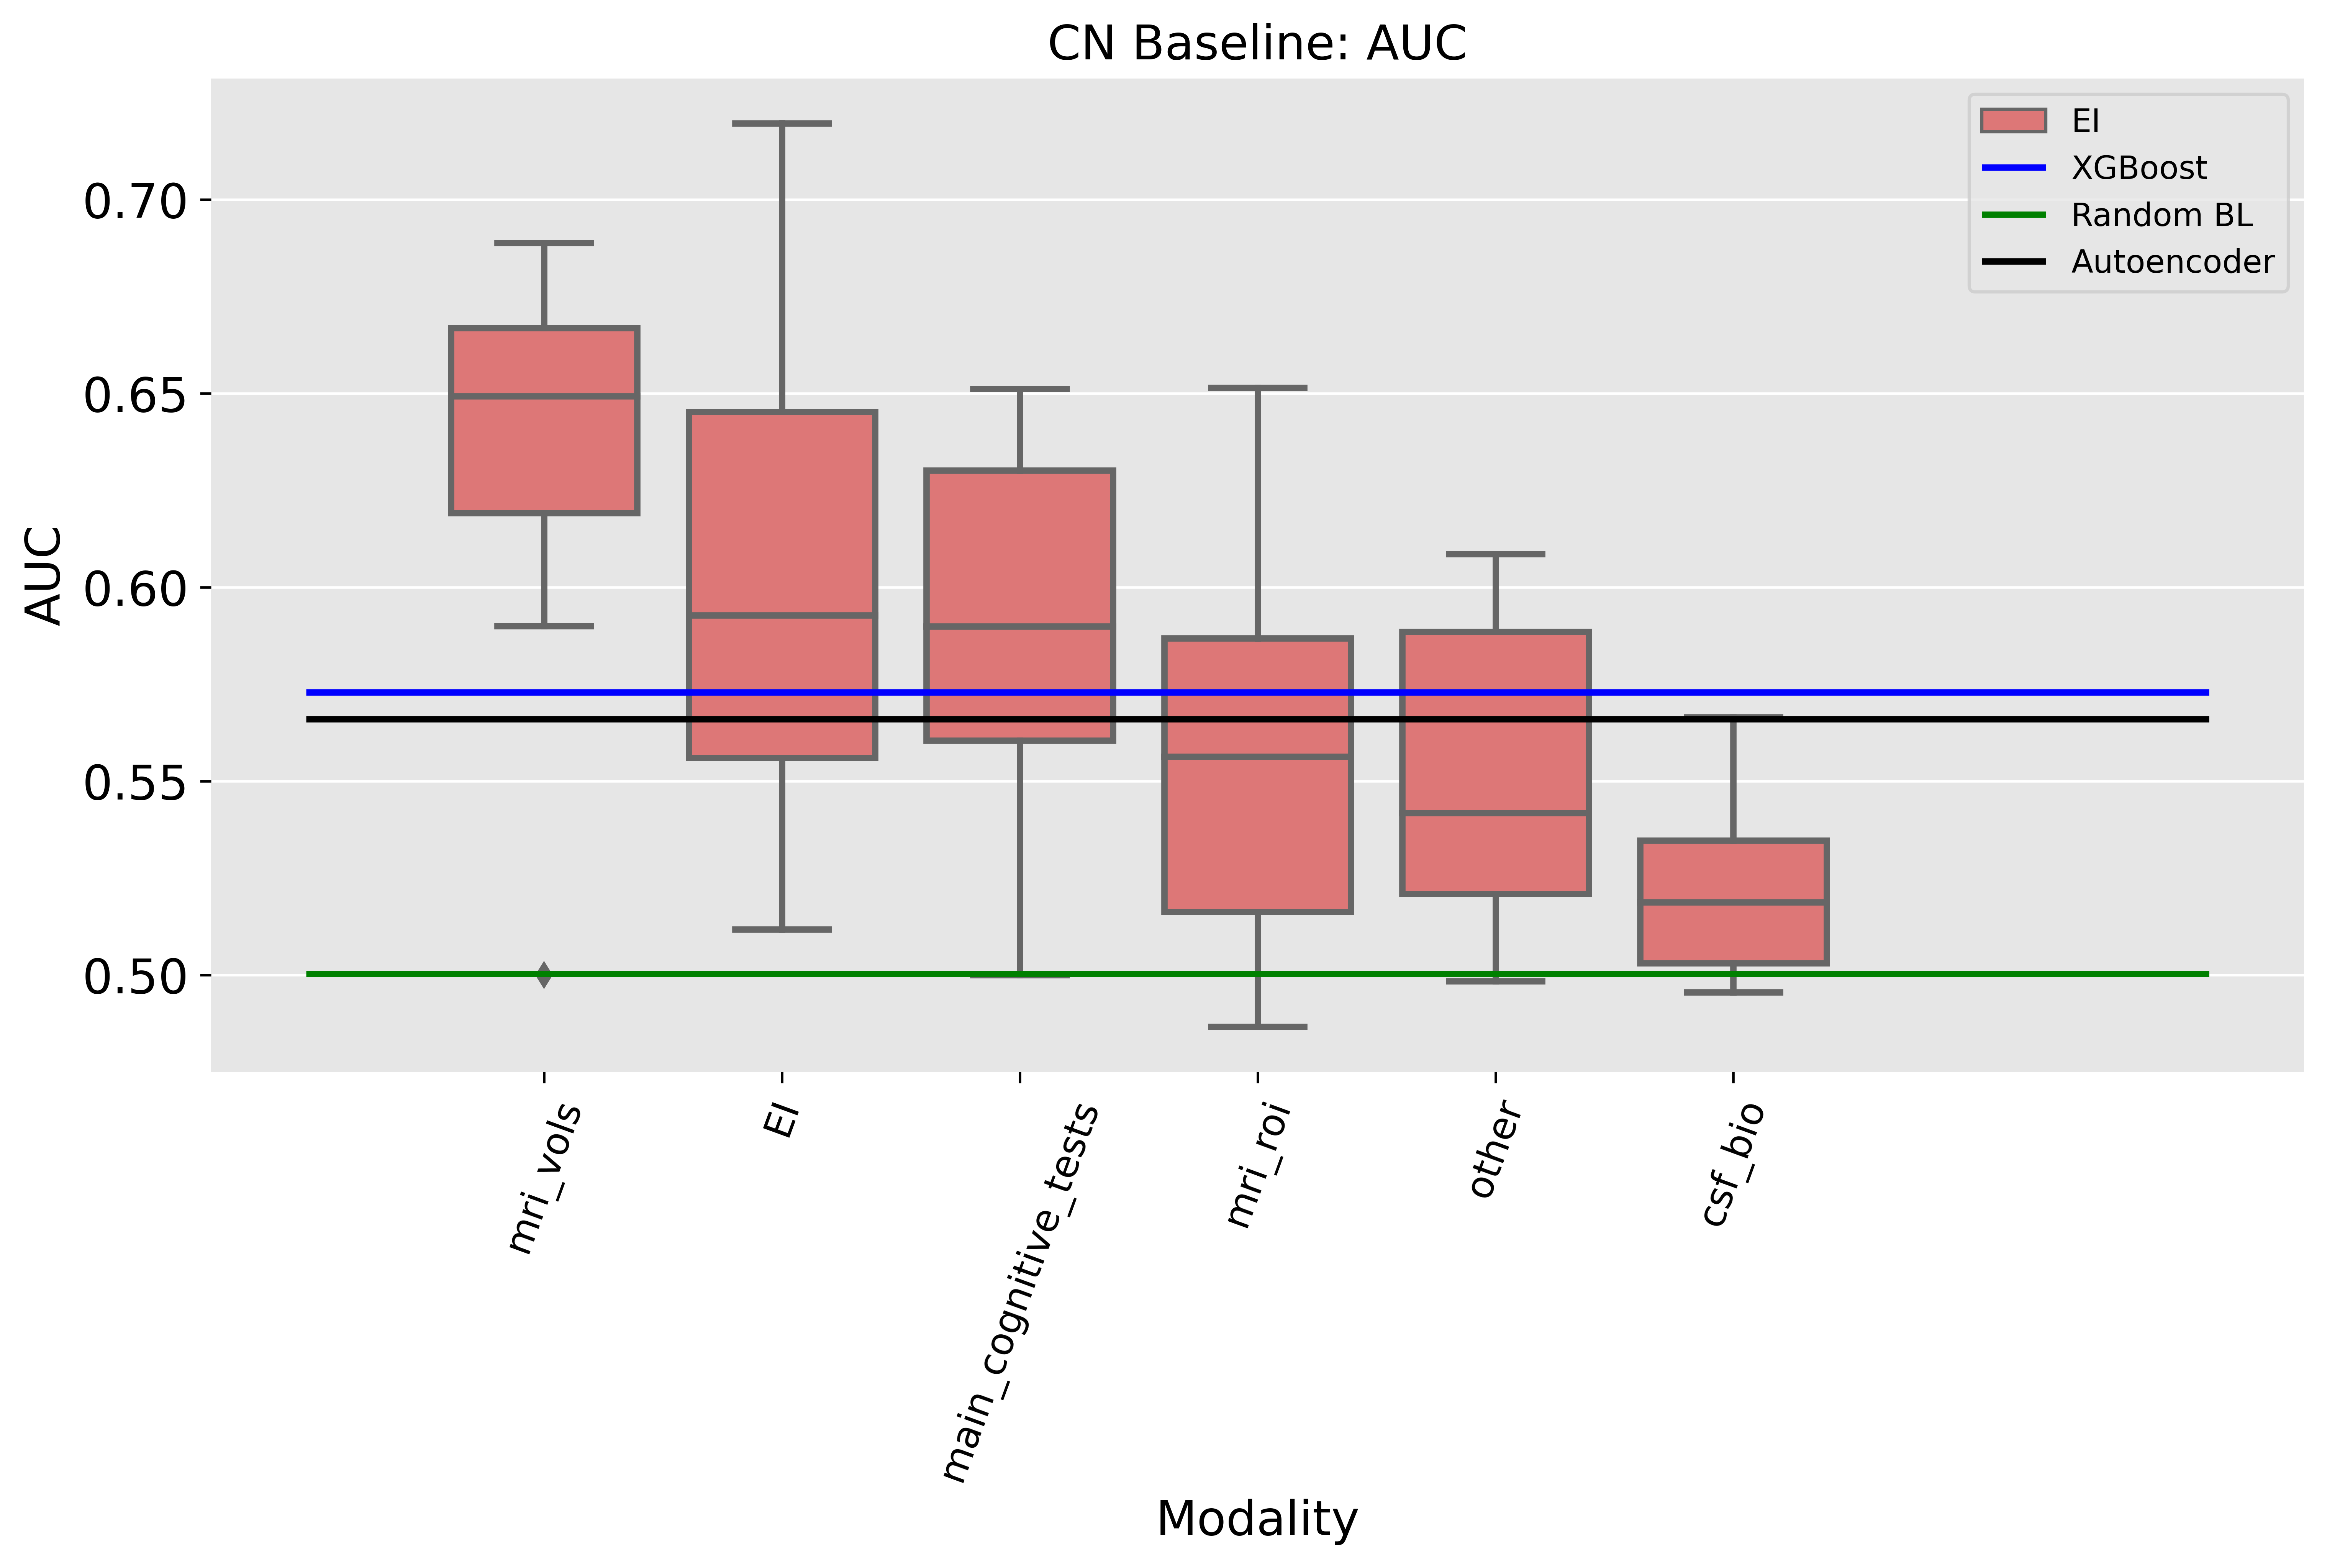

In [25]:
from sklearn.metrics import precision_recall_curve, precision_score, recall_score
import seaborn as sns
import os
import matplotlib.pyplot as plt

for problem in ['MCI', 'CN']:
    if problem == 'CN':
        tempseed = '_43'
    elif problem == 'MCI':
        tempseed = ''
    for metric_num in [0, 1, 2]:
        if metric_num == 0:
            metric = 'fmax (minority)'
        elif metric_num == 1:
            metric = 'f (majority)'
        elif metric_num == 2: 
            metric = 'AUC'

        model_path = '/home/opc/Tadpole_Expanded/'

        ei_model_FULL = EnsembleIntegration.load(model_path + f'EI.{problem}_FULL_{date}')
        ei_model_8020 = EnsembleIntegration.load(model_path + f'EI.{problem}_8020_{date}{tempseed}')
    
        keys = np.unique(ei_model_FULL.base_summary['metrics'].keys().get_level_values(0))
        all_scores_FULL = {}
        all_scores_8020 = {}

        all_scores_FULL['EI'] = get_all_metrics(ei_model_FULL)[metric]
        all_scores_8020['EI'] = get_all_metrics(ei_model_8020)[metric]


        for k in keys:
            mode_FULL = EnsembleIntegration().load(os.path.join(model_path, f'EI.{problem}_FULL_{k}_{date}'))
            mode_8020 = EnsembleIntegration().load(os.path.join(model_path, f'EI.{problem}_8020_{k}_{date}{tempseed}'))

            all_scores_FULL[k] = get_all_metrics(mode_FULL)[metric]
            all_scores_8020[k] = get_all_metrics(mode_8020)[metric]

        all_scores_df_FULL = pd.DataFrame()
        all_scores_df_8020 = pd.DataFrame()

        for keys in all_scores_FULL.keys():
            all_scores_df_FULL = pd.concat([all_scores_df_FULL, pd.DataFrame(all_scores_FULL[keys], columns=[keys])], axis=1)
            all_scores_df_8020 = pd.concat([all_scores_df_8020, pd.DataFrame(all_scores_8020[keys], columns=[keys])], axis=1)

        value_name = metric

        index_sort_FULL = all_scores_df_FULL.median().sort_values(ascending=False).index
        index_sort_8020 = all_scores_df_8020.median().sort_values(ascending=False).index

        all_scores_df_FULL = all_scores_df_FULL[index_sort_FULL]
        all_scores_df_8020 = all_scores_df_8020[index_sort_8020]

        all_scores_df_FULL['exp'] = 'All Data'
        all_scores_df_8020['exp'] = 'EI'

        cdf = pd.concat([all_scores_df_8020], axis=0)
        mdf = pd.melt(cdf, "exp", var_name="Modality", value_name=value_name) 
        
        fig = pretty_fig('', '', '')
        #plt.gcf().subplots_adjust(bottom=0.15)
        plt.rc('xtick', direction='out', color='black', labelsize=15)
        plt.rc('ytick', direction='out', color='black', labelsize=15)
        plt.xticks(rotation=70, fontsize=12)
        ticks = all_scores_df_FULL.keys()
        
        bpl = sns.boxplot(x='Modality', y=value_name, hue='exp', data=mdf) #,palette=my_pal)

        #XG_FULL = EnsembleIntegration.load(f'EI.XG_{problem}_FULL_{date}')
        #XG_FULL_metric = get_all_metrics(XG_FULL, base=True)[metric][0]

        XG_8020 = EnsembleIntegration.load(f'EI.XG_{problem}_8020_{date}{tempseed}')
        XG_8020_metric = get_all_metrics(XG_8020, base=True)[metric][0]

        with open('AE_results_4_10_23.pkl', 'rb') as fp:
            AE_results_4_10_23 = pickle.load(fp)
        AE_8020_metric = AE_results_4_10_23[problem]['8020']['training'][metric]

        xg_rand = []
        for i in range(50):
            XG_8020_random = EnsembleIntegration.load(f'EI.XG_{problem}_RANDOM_8020_{date}_47_repeat_{i}')
            #print(get_all_metrics(XG_8020_random, base=True)[metric][0])
            xg_rand += [get_all_metrics(XG_8020_random, base=True)[metric][0]]

        XG_8020_random_metric = np.median(xg_rand)        
            
        #plt.hlines(XG_FULL_metric[0], xmin = -1, xmax = len(ticks), colors='r', label='XGB All Data', alpha=1)
        plt.hlines(XG_8020_metric, xmin = -1, xmax = len(ticks), colors='b', label='XGBoost', alpha=1)
        plt.hlines(XG_8020_random_metric, xmin = -1, xmax = len(ticks), colors='g', label='Random BL', alpha=1)
        plt.hlines(AE_8020_metric, xmin = -1, xmax = len(ticks), colors='k', label='Autoencoder', alpha=1)
        plt.title(f'{problem} Baseline: {metric}')
        plt.legend()
        plt.show()

# Interpretation

Get EI object

In [2]:
import sys
sys.path.append(path_to_ei)
from ei import *
#from utils import *

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import RobustScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from ei import EnsembleIntegration, MeanAggregation, MedianAggregation
from interpretation import *

EI = EnsembleIntegration(base_predictors=base_pred,
                         k_outer=5,
                         k_inner=5,
                         n_samples=1,
                         sampling_strategy="hybrid",
                         sampling_aggregation="mean",
                         n_jobs=-1,  # set as -1 to use all available CPUs
                         random_state=44,
                         project_name="demo")
if 'CES' in meta_models:    
    del meta_models['CES']

Jamie's way

In [2]:
import numpy as np
import dill
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import RobustScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import sys
import os
import pandas as pd
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV, Lasso, ElasticNet
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.base import clone
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.calibration import CalibratedClassifierCV

import os

#path_to_dwt_utils = "/home/opc/storage/cell-division/modelling/ei-transformations/discrete-wavelet"
#sys.path.append(path_to_dwt_utils)

#from dwt_utils import low_pass_filter, dwt

from sklearn.preprocessing import StandardScaler

path_to_ei = "/home/opc/ei-python-jamie/"
sys.path.append(path_to_ei)
from ei import EnsembleIntegration
from utils import *
from interpretation import *
from interpretation import EI_interpreter

from sklearn.datasets import make_classification

model_date = '3_22_2023'
model_path = '/home/opc/Tadpole_Expanded'
problem = 'MCI'
EI_int_dict = {}
#EI = EnsembleIntegration()
for data_split in ['FULL', '8020']:

    EI = EnsembleIntegration().load(os.path.join(model_path, (f'EI.{problem}_{data_split}_{model_date}')))
    x = full_and_split[problem][data_split]['ext_test']
    y = full_and_split[problem][data_split]['ext_test_labels'].astype(int)
    #EI = EI.load(os.path.join(path_to_models, "EI." + key))

    #id = '_'.join(modalities.keys())

    from sklearn.metrics import average_precision_score

    EI_int = EI_interpreter(EI=EI,
                            metric=f_minor_sklearn, 
                            n_repeats=100,
                            ensemble_methods="all")
    EI_int.local_feature_rank(x, y) 
    EI_int.local_model_rank(ensemble_model_keys=["Mean", "CES", "S.LR", "S.RF"])

    

    EI_int_dict[data_split] = EI_int.rank_product_score(x, y)

    #EI_int.ensemble_feature_ranking['S.LR'].to_csv(os.path.join(save_path, "interpretation" + id + "1" + ".csv" ))

    #EI_int.LFR.to_csv(os.path.join(save_path, "LFR" + id + "1" + ".csv" ))

    #EI_int.LMR.to_csv(os.path.join(save_path, "LMR" + id + "1" + ".csv" ))

AttributeError: 'Perceptron' object has no attribute 'predict_proba'

In [3]:
from sklearn.metrics import average_precision_score
from utils import f_minor_sklearn, f_minority_score
import os
for problem in ['MCI']:
    model_date = '3_22_2023'
    tadpole_dict = pd.read_csv('TADPOLE_D1_D2_Dict.csv')
    model_path = '/home/opc/Tadpole_Expanded'
    EI_int_dict = {}
    EI_int_dict[problem] = {}
    for data_split in ['FULL', '8020']:

        EI_model = EnsembleIntegration().load(os.path.join(model_path, (f'EI.{problem}_{data_split}_{model_date}')))

        x = full_and_split[problem][data_split]['train']
        y = full_and_split[problem][data_split]['labels'].astype(int)
        x_filtered = full_and_split[problem][f'{data_split}_DF']

        if data_split == 'FULL':
            fdr_csv = 'FDR_MCI_FINAL.csv'
        elif data_split == '8020':
            fdr_csv = 'MCI_8020_FDR.csv'

        EI_int_dict[problem][f'{github_version}_{data_split}_object'] = EI_interpreter(EI_object=EI,
                                    base_predictors=base_pred,
                                    meta_models=meta_models,
                                    modalities=x,
                                    y=y,
                                    n_repeats = 10,
                                    metric=f_minority_score)
                                    #metric = f_minor_sklearn)
        
        EI_int_dict[problem][f'{github_version}_{data_split}_object'].rank_product_score()
        EI_int_dict[problem][data_split] = get_labels_for_int_feature_rank(EI_int_dict[problem][f'{github_version}_{data_split}_object'], EI_model, x_filtered)
        EI_int_dict[problem][data_split].to_csv(os.path.join(f'{model_path}',f'{github_version}_EI_{problem}_int_{data_split}_no_fdr_{date}'))
        add_fdr_to_int(f'{github_version}_EI_{problem}_int_{data_split}_no_fdr_{date}', fdr_csv, f'{github_version}_EI_{problem}_int_{data_split}_fdr_{date}.csv')
        EI_int_dict[problem][f'{github_version}_{data_split}_csv'] = pd.read_csv(f'{github_version}_EI_{problem}_int_{data_split}_fdr_{date}.csv')



 Working on main_cognitive_tests data... 

Training base predictors on outer training sets...

 Working on mri_roi data... 

Training base predictors on outer training sets...

 Working on mri_vols data... 

Training base predictors on outer training sets...

 Working on csf_bio data... 

Training base predictors on outer training sets...

 Working on other data... 

Training base predictors on outer training sets...
      local_model_PI base predictor              modality ensemble_method  \
0           0.003318             NB  main_cognitive_tests    S.S.AdaBoost   
1           0.003318             NB  main_cognitive_tests    S.S.AdaBoost   
2           0.003318             NB  main_cognitive_tests    S.S.AdaBoost   
3           0.003318             NB  main_cognitive_tests    S.S.AdaBoost   
4           0.003318             NB  main_cognitive_tests    S.S.AdaBoost   
...              ...            ...                   ...             ...   
3425        0.000000            KNN    

Plot interpretation consistency

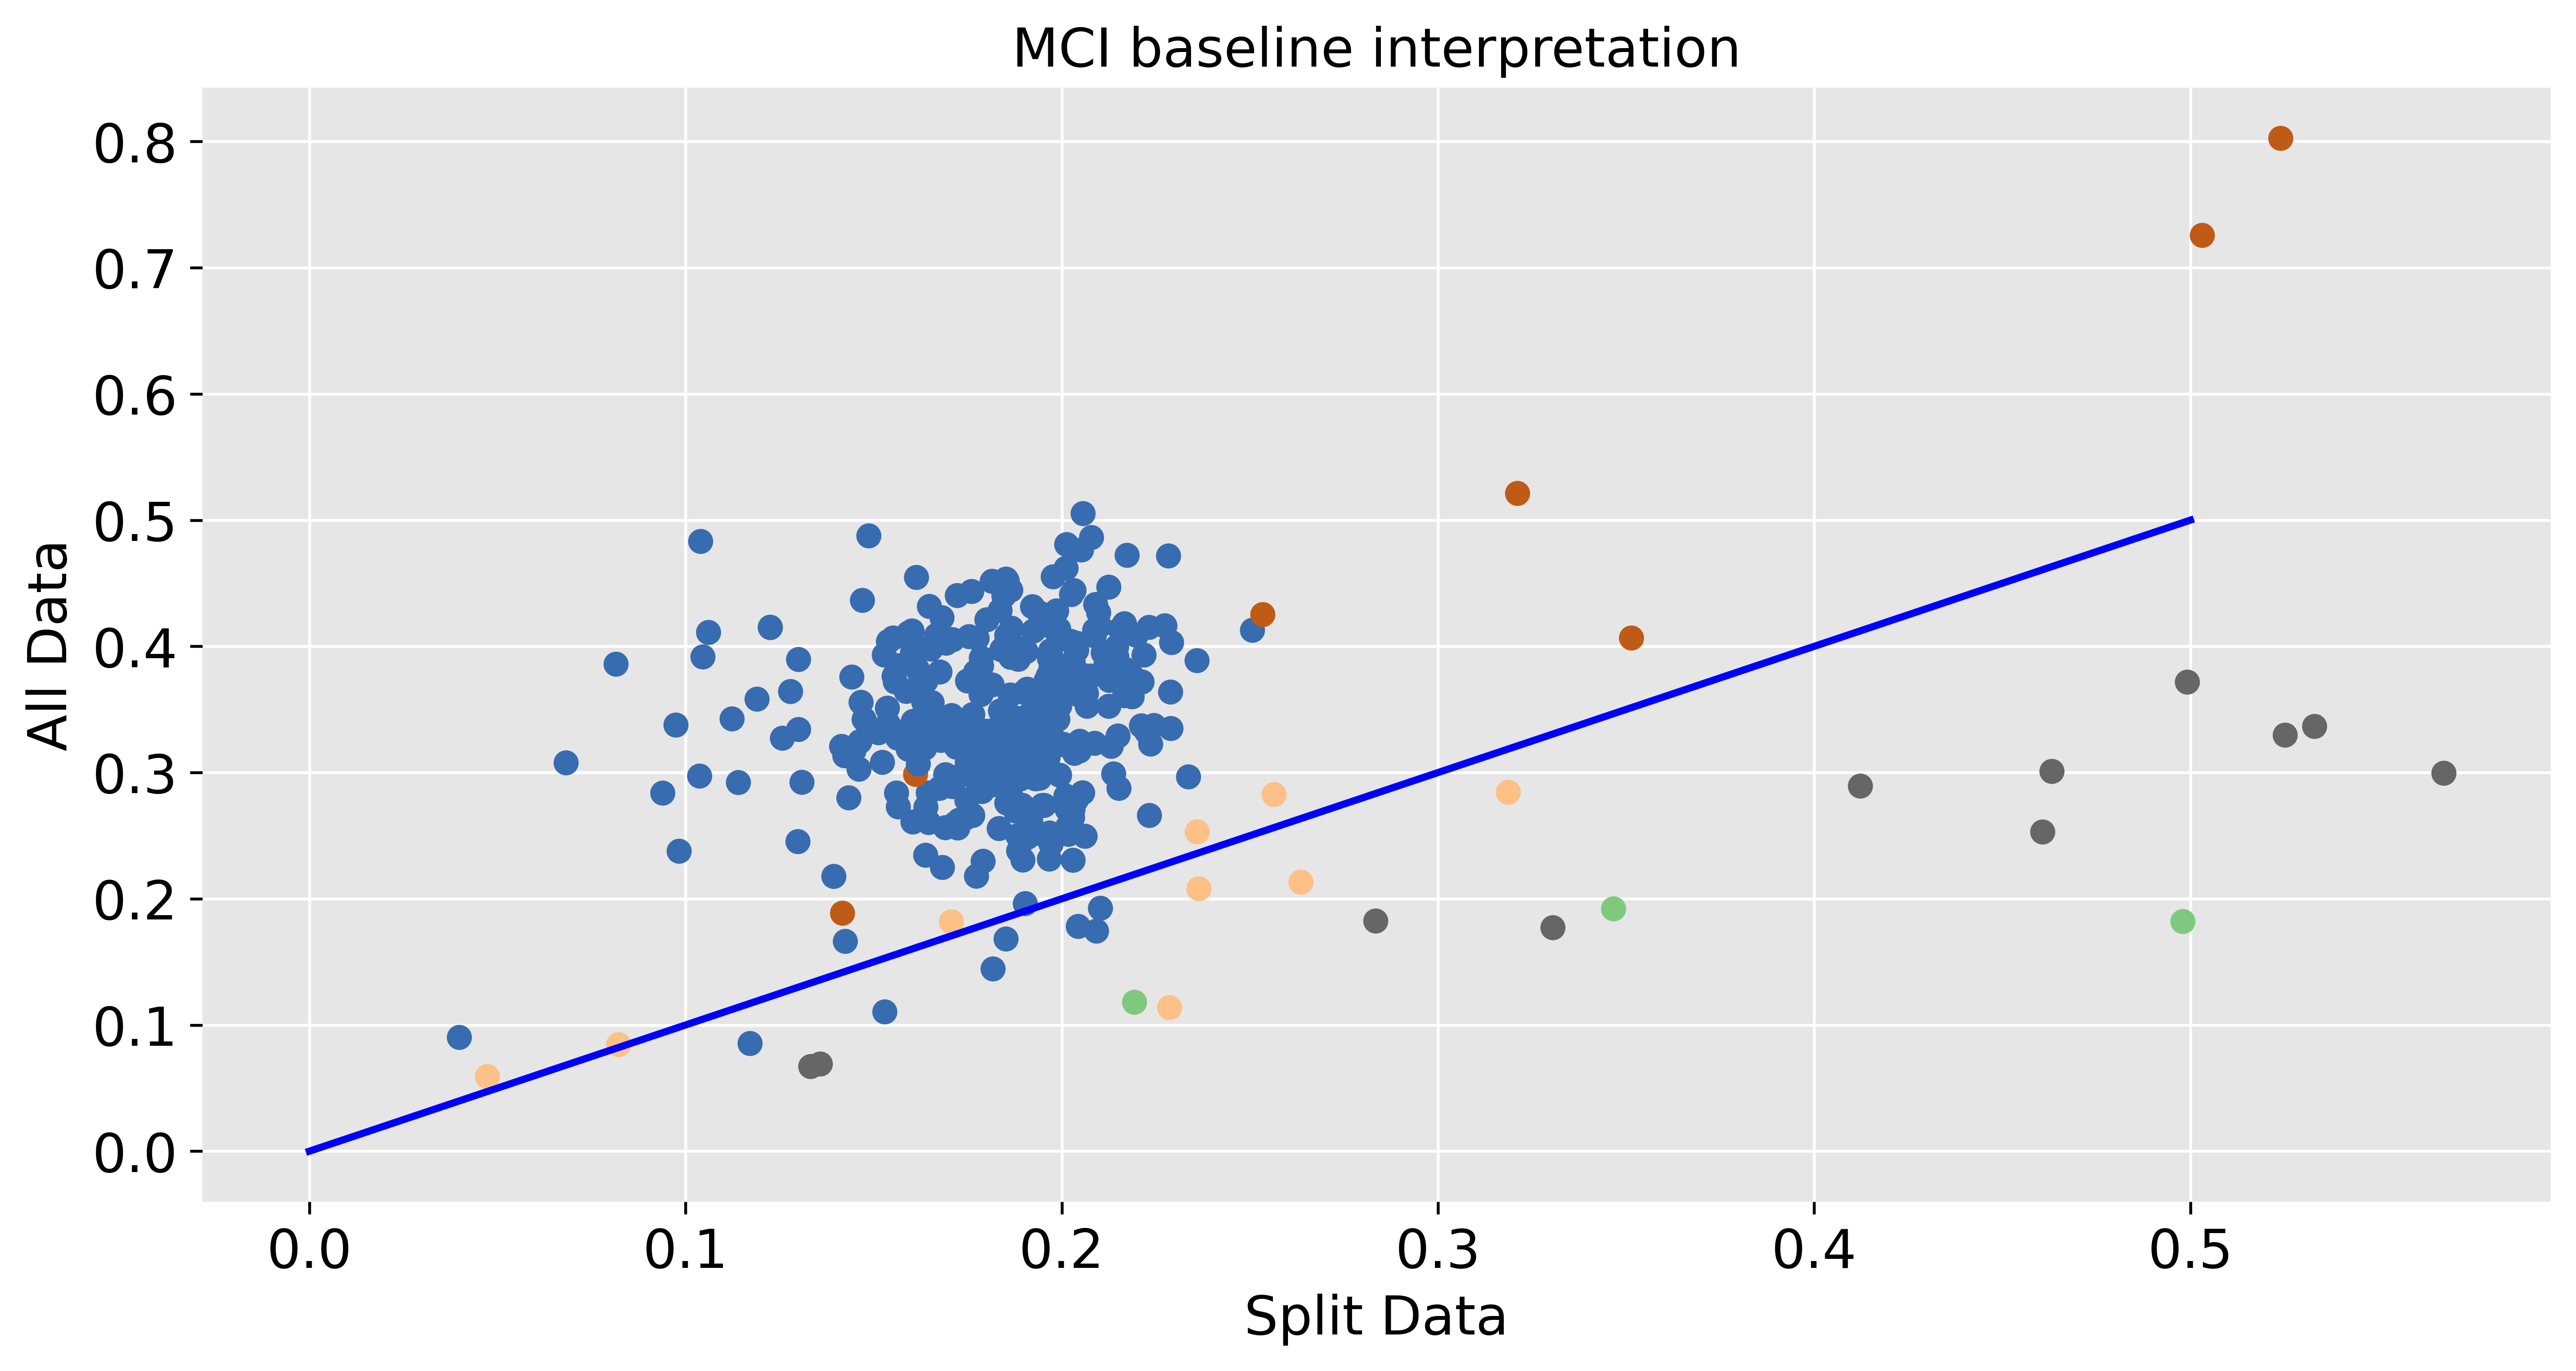

In [9]:
variable = 'RPS'
cmap = 'Accent'
for problem in ['MCI']:
    modalities = np.unique(EI_int_dict[problem]['FULL_object'].LFRs['modality'])
    mode_labels = {}
    for i, mode in enumerate(modalities):
        mode_labels[mode] = i
    fig = pretty_fig('','','')
    int_full = EI_int_dict[problem]['FULL_csv']
    int_8020 = EI_int_dict[problem]['8020_csv']

    rank={}
    rank_all = []
    rank_split = []
    color_by_mode = []
    for feat in int_full['feature']:
        rank_all += [int_full[int_full['feature'] == feat][variable]]
        rank_split += [int_8020[int_8020['feature'] == feat][variable]]
        color_by_mode += [mode_labels[list(int_full[int_full['feature'] == feat]['modality'])[0]]]

    plt.scatter(rank_split, rank_all, c=color_by_mode, cmap=cmap, alpha=1)

    plt.xlabel('Split Data')
    plt.ylabel('All Data')
    plt.title(f'{problem} baseline interpretation')
    plt.plot([0,.5], [0, .5], color='b')
    plt.plot()

# Analysis

In [45]:
scan_code = full_and_split[problem][f'{data_split}_DF'][modality].columns
tadpole_dict = pd.read_csv('TADPOLE_D1_D2_Dict.csv')
new_labels = []
for sc in scan_code:
    if sc in list(tadpole_dict['FLDNAME']): 
        new_labels += [list(tadpole_dict[tadpole_dict['FLDNAME'] == sc]['TEXT'])[0]]

In [47]:
problem = 'MCI'
data_split = 'FULL'
modality = 'mri_roi'
mri_roi_df = pd.DataFrame(full_and_split[problem][data_split]['train'][modality], columns = new_labels)

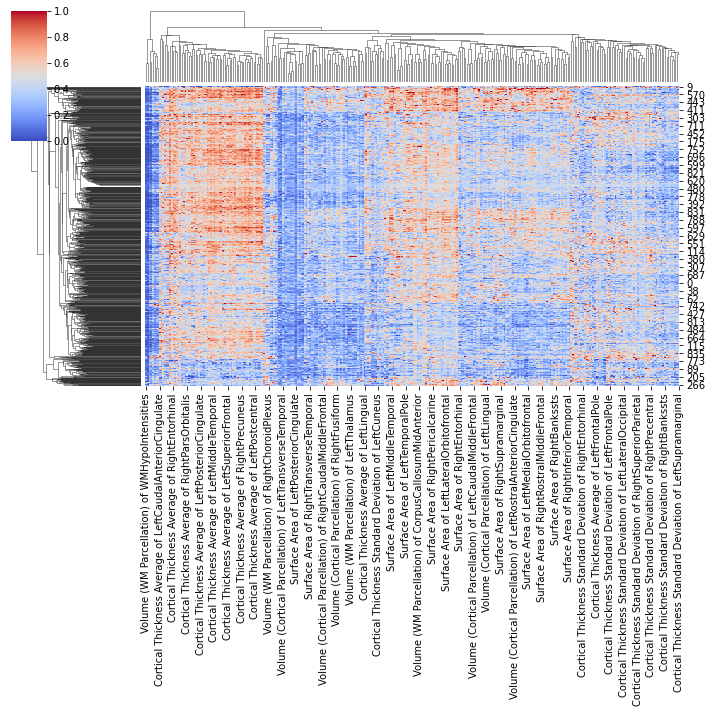

In [53]:
import seaborn as sns
cmap = sns.diverging_palette(230, 20, as_cmap = True)
sns.clustermap(mri_roi_df, standard_scale=1, cmap="coolwarm")

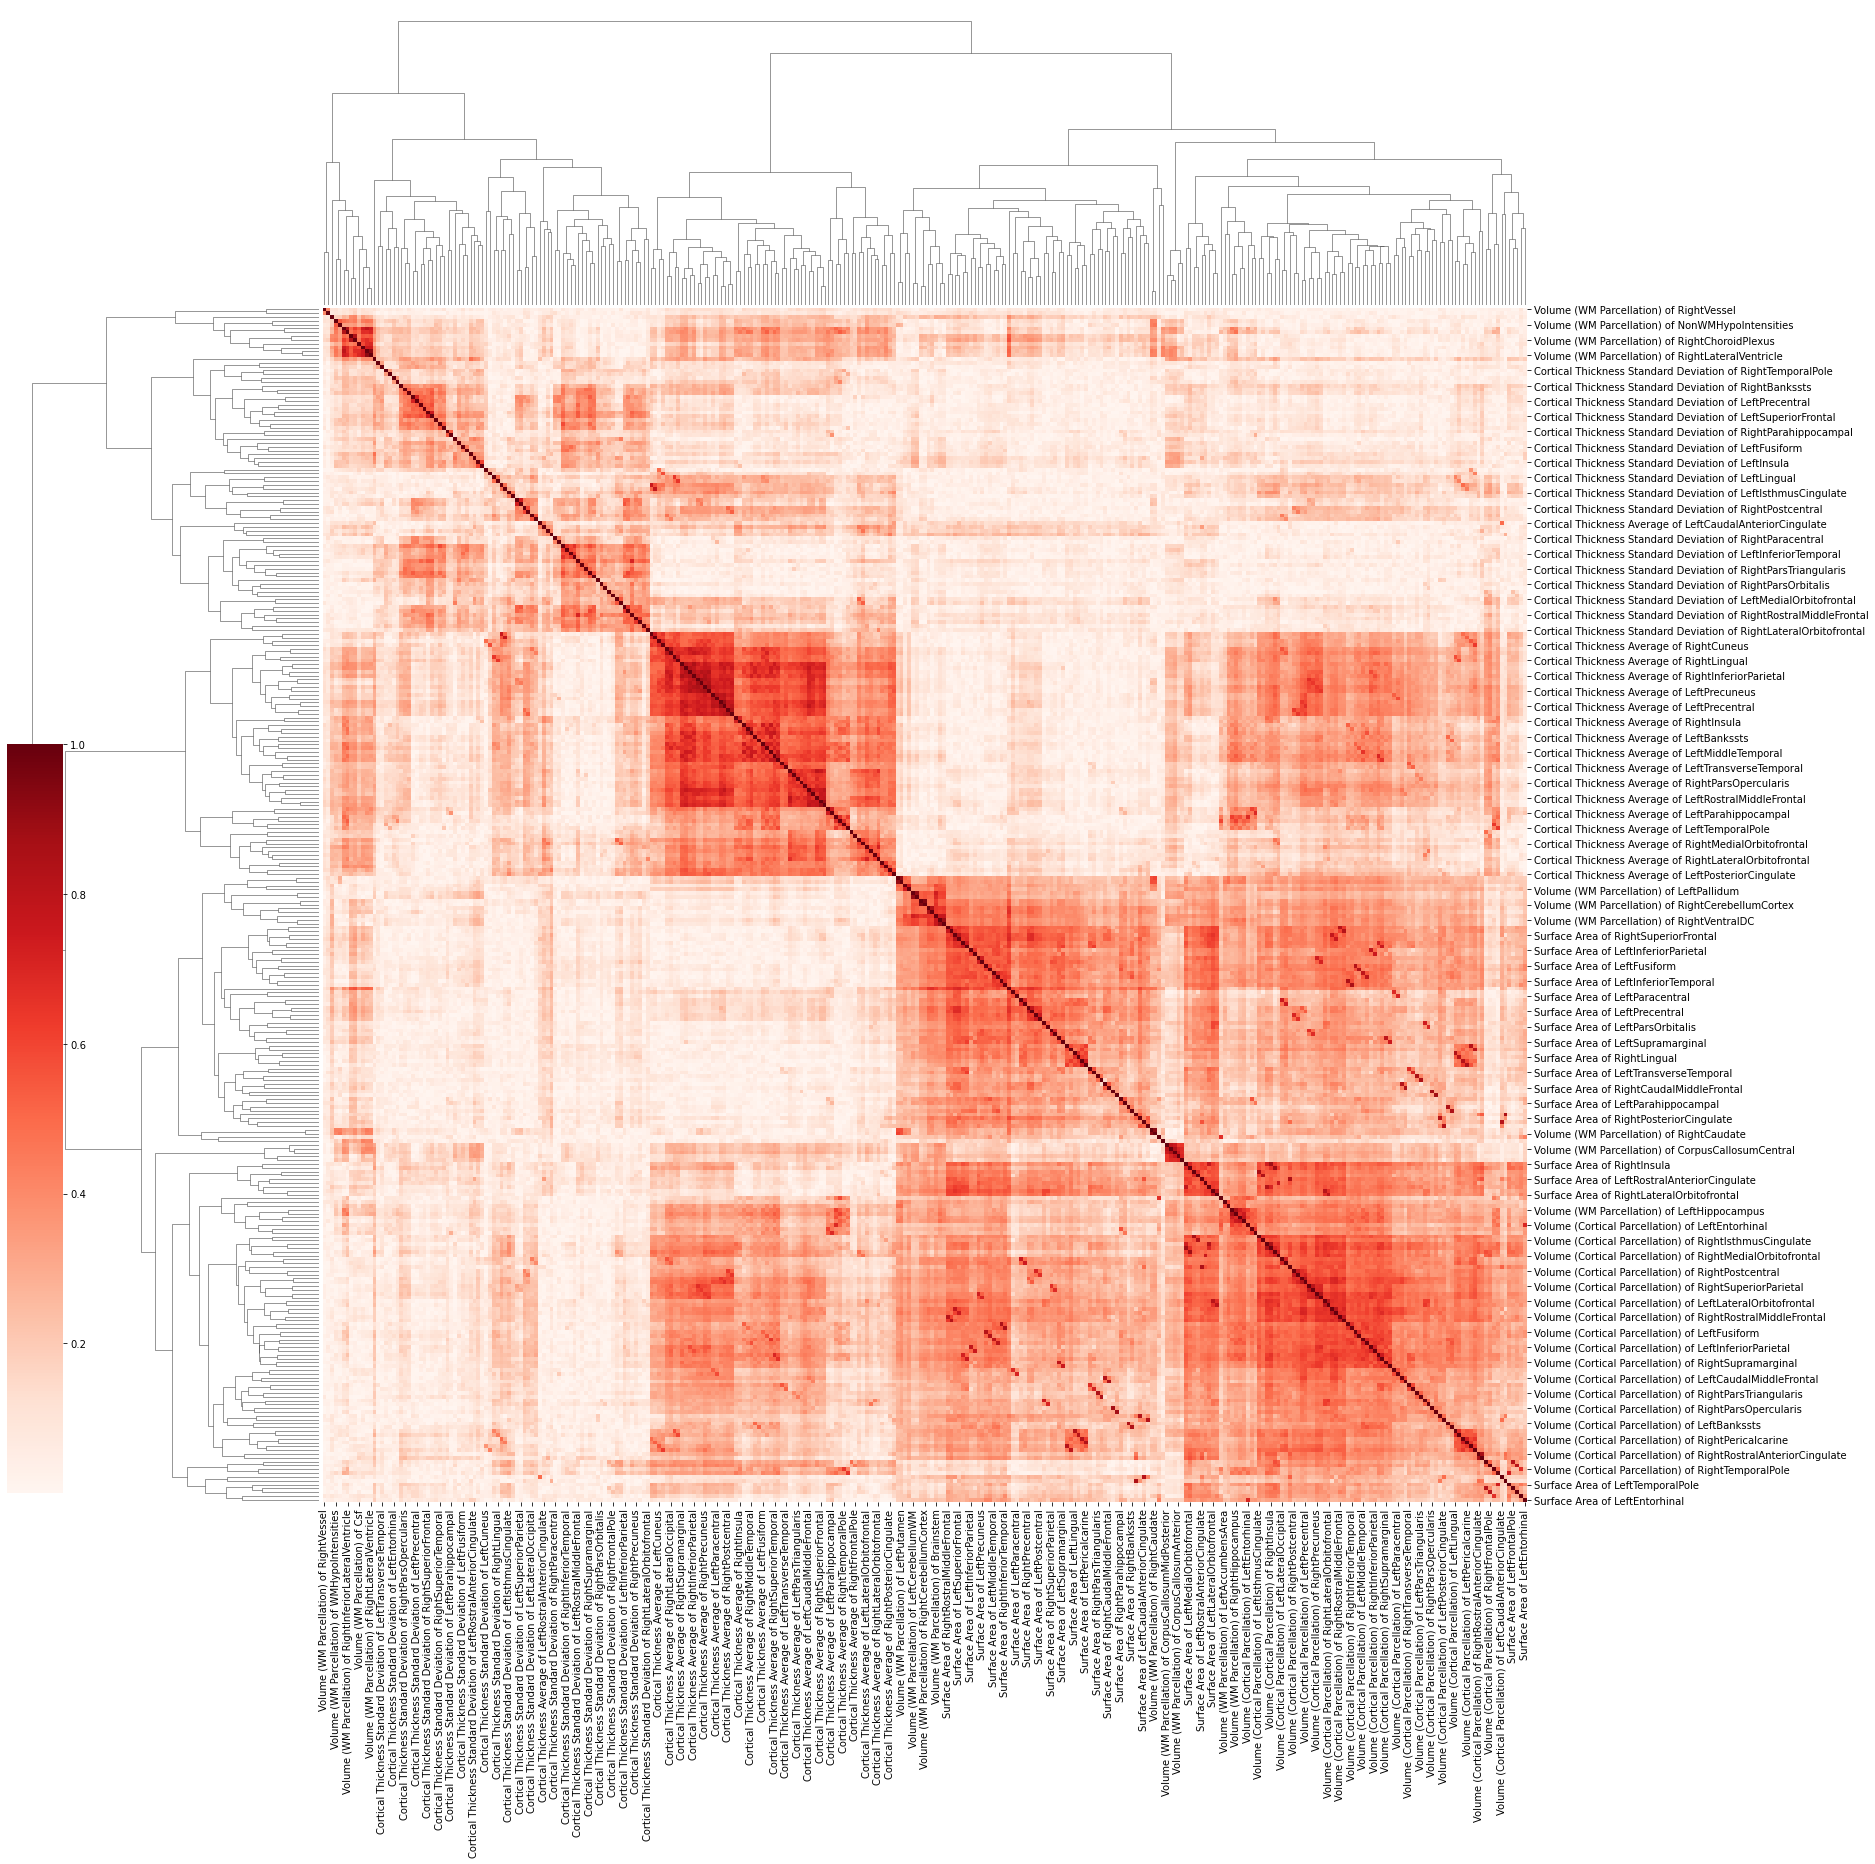

In [54]:
from scipy.spatial import distance
from scipy.cluster import hierarchy

corr = mri_roi_df.corr()
corr_array = np.asarray(corr)
row_linkage = hierarchy.linkage(
    distance.pdist(corr_array), method='average')
col_linkage = hierarchy.linkage(
    distance.pdist(corr_array.T), method='average')
cmap = 'Reds'
#mask = np.triu(np.ones_like(corr, dtype=bool))
sns.clustermap(abs(corr), row_linkage=row_linkage, col_linkage=col_linkage, method="average", figsize=(26, 26), cbar_pos=(0, .2, .03, .4), cmap=cmap)

In [ ]:
variable = 'RPS'
cmap = plt.cm.coolwarm
modalities = np.unique(EI_int_dict['FULL_object'].LFRs['modality'])
mode_labels = {}
for i, mode in enumerate(modalities):
    mode_labels[mode] = i
plt.figure(figsize=(6,6))

int_full = EI_int_dict['FULL_csv']
int_8020 = EI_int_dict['8020_csv']

rank={}
rank_all = []
rank_split = []
full_sig = []
split_sig = []
color_by_mode = []
for feat in int_full['feature']:

    rank_all += [int_full[int_full['feature'] == feat][variable]]
    rank_split += [int_8020[int_8020['feature'] == feat][variable]]
    full_sig += [int_full[int_full['feature'] == feat]['Significant']]
    split_sig += [int_8020[int_8020['feature'] == feat]['Significant']]
    color_by_mode += [mode_labels[list(int_full[int_full['feature'] == feat]['modality'])[0]]]

plt.scatter(rank_split, rank_all, c=color_by_mode, cmap=cmap, alpha=1)

plt.xlabel('Split Data')
plt.ylabel('All Data')

plt.plot([0,.5], [0, .5], color='b')
plt.plot()